# 1. 광합성

[Cropbox](https://github.com/cropbox/Cropbox.jl)는 작물모형 개발을 도와주는 프레임워크입니다. 프레임워크에 대한 개략적인 소개는 2021 한국원예학회 추계학술발표회의 [발표](https://drive.google.com/file/d/10VaQ6tSRUN3lj5HiMbXC5UKNktv1uucN/view?usp=sharing)나 JuliaCon 2022의 [발표](https://youtu.be/l43ldy_L35A)를 참고해주시기 바랍니다.

이번 시간에는 오전에 실습하였던 광합성 모형을 Cropbox로 만드는 방법에 대해서 살펴보도록 하겠습니다. 먼저 Cropbox 패키지를 불러옵니다.

In [1]:
using Cropbox

JupyterHub 환경에서 움직이는 그래프를 그리기 위해 필요한 설정을 해줍니다.

In [2]:
Cropbox.Interact.WebIO.setup(:ijulia)

WebIO._IJuliaInit()

광합성 모형 내부에서 최적화 작업을 수행할 때 입력 환경 조건에 따라 값을 찾지 못하는 경우가 있습니다. 특히 일반적이지 않은 조건으로 테스트할 때 발생하는 경우가 많은데요. 관련 경고 메시지를 보이지 않게 해줍니다.

In [3]:
using Logging
Logging.disable_logging(Logging.Warn)

LogLevel(1001)

## 1.1. 모형 구현

오늘 다루는 기체교환(gas exchange) 모형은 옥수수 모형인 [MAIZSIM](https://github.com/ARS-CSGCL-DT/MAIZSIM)에서 C++ 언어로 구현되어 있던 것을 마늘 모형인 [Garlic.jl](https://github.com/cropbox/Garlic.jl)을 Cropbox 기반으로 구현하면서 개발한 것입니다. [LeafGasExchange.jl](https://github.com/cropbox/LeafGasExchange.jl)라는 이름의 독립된 Julia 패키지로도 배포되고 있습니다. 기체 교환은 생화학적인 광합성 뿐만 아니라 기공의 반응, 이에 따른 증산에 의한 엽온 변화까지 함께 다룹니다.

여기에서는 해당 패키지와 거의 동일한 구조를 따르며 한 부분씩 모형을 만들어 조립해보겠습니다. 우선 세부 모형의 종류와 상관 없이 공통적으로 필요한 구성요소들을 확인합니다.

In [4]:
import LeafGasExchange

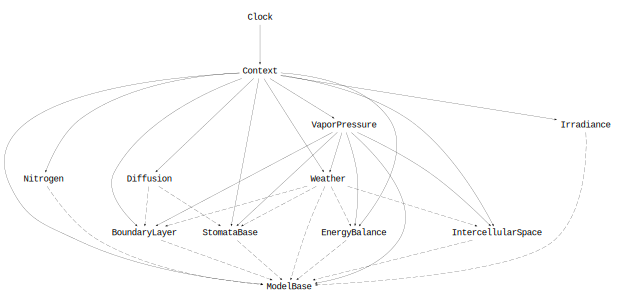

In [5]:
Cropbox.hierarchy(LeafGasExchange.ModelBase)

### 1.1.1. 환경 요인

광합성(기체 교환) 모형은 외부 환경 요인의 변화에 반응하도록 되어 있습니다. 이에 관련된 환경 변수들, 특히 대기(atmosphere)에 관한 것들을 미리 준비해놓겠습니다.

#### 1.1.1.1. 증기압 (vapor pressure)

$$
e_s[T] = 0.611 \cdot \exp\!\left[ \frac{17.502 \cdot T}{240.97 + T} \right]
$$

In [6]:
@system VaporPressure begin
    a => 0.611  ~ preserve(parameter, u"kPa")
    b => 17.502 ~ preserve(parameter)
    c => 240.97 ~ preserve(parameter)

    es(a, b, c; T(u"°C")):                 saturation        => (t = deunitfy(T); a*exp((b*t)/(c+t))) ~ call(u"kPa")
    ea(es;      T(u"°C"), RH(u"percent")): ambient           => es(T) * RH                            ~ call(u"kPa")
    D(es;       T(u"°C"), RH(u"percent")): deficit           => es(T) * (1 - RH)                      ~ call(u"kPa")
    RH(es;      T(u"°C"), VPD(u"kPa")):    relative_humidity => 1 - VPD / es(T)                       ~ call(u"NoUnits")

    Δ(es, b, c; T(u"°C")):            saturation_slope_delta => (e = es(T); t = deunitfy(T); e*(b*c)/(c+t)^2 / u"K") ~ call(u"kPa/K")
    s(Δ;        T(u"°C"), P(u"kPa")): saturation_slope       => Δ(T) / P                                             ~ call(u"K^-1")
end

VaporPressure

#### 1.1.1.2. 기상 자료 (weather)

In [7]:
@system Weather begin
    vp(context): vapor_pressure ~ ::VaporPressure

    PFD:           photon_flux_density      => 2000 ~ preserve(parameter, u"μmol/m^2/s")
    CO2:           carbon_dioxide           => 400  ~ preserve(parameter, u"μmol/mol")
    RH:            relative_humidity        => 66   ~ preserve(parameter, u"percent")
    T_air:         air_temperature          => 32   ~ preserve(parameter, u"°C")
    Tk_air(T_air): absolute_air_temperature         ~ track(u"K")
    wind:          wind_speed               => 2.0  ~ preserve(parameter, u"m/s")
    P_air:         air_pressure             => 99.4 ~ preserve(parameter, u"kPa")

    VPD(T_air, RH, D=vp.D):      vapor_pressure_deficit                => D(T_air, RH)    ~ track(u"kPa")
    VPD_Δ(T_air, Δ=vp.Δ):        vapor_pressure_saturation_slope_delta => Δ(T_air)        ~ track(u"kPa/K")
    VPD_s(T_air, P_air, s=vp.s): vapor_pressure_saturation_slope       => s(T_air, P_air) ~ track(u"K^-1")
end

Weather

#### 1.1.1.3. 기체 확산 (diffusion)

| Symbol | Value | Units | Description |
|:-------|:------|:------|:------------|
$\mathcal{D}_w$ | 24.2 | $$\mathrm{mm^2}\ \mathrm{s^{-1}}$$ | Diffusion coefficient for water vapor ($\mathrm{H_2O}$) in air at 20 $\mathrm{^{\circ}C}$ |
$\mathcal{D}_c$ | 14.7 | $\mathrm{mm^2}\ \mathrm{s^{-1}}$ | Diffusion coefficient for $\mathrm{CO_2}$ in air at 20 $\mathrm{^{\circ}C}$ |
$\mathcal{D}_h$ | 21.5 | $\mathrm{mm^2}\ \mathrm{s^{-1}}$ | Diffusion coefficient for heat (thermal diffusivity) in air at 20 $\mathrm{^{\circ}C}$ |
$\mathcal{D}_m$ | 15.1 | $\mathrm{mm^2}\ \mathrm{s^{-1}}$ | Diffusion coefficient for momentum (kinematic viscosity) in air at 20 $\mathrm{^{\circ}C}$ |

In [8]:
@system Diffusion begin
    Dw: diffusion_coeff_for_water_vapor_in_air_at_20 => 24.2 ~ preserve(parameter, u"mm^2/s")
    Dc: diffusion_coeff_for_co2_in_air_at_20         => 14.7 ~ preserve(parameter, u"mm^2/s")
    Dh: diffusion_coeff_for_heat_in_air_at_20        => 21.5 ~ preserve(parameter, u"mm^2/s")
    Dm: diffusion_coeff_for_momentum_in_air_at_20    => 15.1 ~ preserve(parameter, u"mm^2/s")
end

Diffusion

#### 1.1.1.4. 조도 (irradiance)

$$
\begin{align}
I_2 &= \frac{(1 - f)}{2} I_a \\
I_a &= \alpha I
\end{align}
$$

| Symbol | Units | Description |
|:-------|:------|:------------|
$I$ | $$\mathrm{\mu mol_{quanta}}\ \mathrm{m^{-2}}\ \mathrm{s^{-1}}$$ | Incident PAR (photosynthetically active radiation) |
$I_a$ | $\mathrm{\mu mol_{quanta}}\ \mathrm{m^{-2}}\ \mathrm{s^{-1}}$ | Absorbed PAR (photosynthetically active radiation) |
$I_2$ | $\mathrm{\mu mol_{quanta}}\ \mathrm{m^{-2}}\ \mathrm{s^{-1}}$ | Effective PAR (photosynthetically active radiation) |

| Symbol | Value | Units | Description |
|:-------|:------|:------|:------------|
$\alpha$ | 0.85 | - | Leaf absorptance in PAR (photosynthetically active radiation) |
$\delta$ | 0.15 | - | Leaf scattering factor |
$f$ | 0.15 | - | Leaf spectral correction factor |

In [9]:
@system Irradiance begin
    PFD ~ hold
    PPFD(PFD): photosynthetic_photon_flux_density ~ track(u"μmol/m^2/s")

    δ: leaf_scattering          => 0.15 ~ preserve(parameter)
    f: leaf_spectral_correction => 0.15 ~ preserve(parameter)

    Ia(PPFD, δ): absorbed_irradiance  => (PPFD * (1 - δ))   ~ track(u"μmol/m^2/s")
    I2(Ia, f):   effective_irradiance => (Ia * (1 - f) / 2) ~ track(u"μmol/m^2/s")
end

Irradiance

### 1.1.2. 광합성

생화학적인 광합성을 다루는 부분입니다. 오전에 다루었던 FvCB 모형에 해당합니다.

여기서는 기본적인 FvCB 모형에서 조금 더 나아가 주요 모수들이 온도나 질소 등 외부 요인에 의해 반응하도록 개량된 수식을 구현하겠습니다.

#### 1.1.2.1. 온도 의존성 (temperature dependence)

$$
\begin{align}
k_{T_A}[T_k, E_a] &= \exp\!\left[ \frac{E_a ( T_k - T_{b_k} )}{R \cdot T_k \cdot T_{b_k}} \right] \\
k_{T_Q}[T] &= Q_{10}^{\frac{T - T_b}{10}} \\
k_{T_P}[T_k, E_a, H, S] &= k_{T_A}[T_k, E_a] \cdot \left( 1 + \exp\!\left[ \frac{S \cdot T_{b_k} - H}{R \cdot T_{b_k}} \right] \right) \left( 1 + \exp\!\left[ \frac{S \cdot T_k - H}{R \cdot T_k} \right] \right)^{-1} \\
\end{align}
$$

| Symbol | Units | Description |
|:-------|:------|:------------|
| $k_{T_A}$ | - | Temperature dependence by Arrhenius equation |
| $k_{T_Q}$ | - | Temperature dependence by $Q_{10}$ function |
| $k_{T_P}$ | - | Temperature dependence by a peaked function |
| $T_a$ | $\mathrm{^{\circ}C}$ | Air temperature in Celsius |
| $T_{a_k}$ | $\mathrm{K}$ | Air temperature in Kelvin |
| $T_l$ | $\mathrm{^{\circ}C}$ | Leaf temperature in Celsius |
| $T_{l_k}$ | $\mathrm{K}$ | Leaf temperature in Kelvin |

| Symbol | Value | Units | Description |
|:-------|:------|:------|:------------|
$R$ | 8.314 | $$\mathrm{J}\ \mathrm{K^{-1}}\ \mathrm{mol}$$ | Universal gas constant |

In [10]:
@system TemperatureDependence begin
    T: leaf_temperature ~ hold
    Tk(T): absolute_leaf_temperature ~ track(u"K")

    Tb: base_temperature               => 25 ~ preserve(parameter, u"°C")
    Tbk(Tb): absolute_base_temperature       ~ preserve(u"K")

    kT(T, Tk, Tb, Tbk; Ea(u"kJ/mol")): arrhenius_equation => begin
        exp(Ea * (T - Tb) / (u"R" * Tk * Tbk))
    end ~ call

    kTpeak(Tk, Tbk, kT; Ea(u"kJ/mol"), S(u"J/mol/K"), H(u"kJ/mol")): peaked_function => begin
        R = u"R"
        kT(Ea) * (1 + exp((S*Tbk - H) / (R*Tbk))) / (1 + exp((S*Tk - H) / (R*Tk)))
    end ~ call

    Q10 => 2 ~ preserve(parameter)
    kTQ10(T, Tb, Q10): q10_rate => begin
        Q10^((T - Tb) / 10u"K")
    end ~ track
end

TemperatureDependence

#### 1.1.2.2. 질소 의존성 (nitrogen dependence)

$$
k_{N} = \frac{2}{1 + \exp\!\left[ -s \cdot \max \{ N_0, N \} - N_0 \right]} - 1
$$

| Symbol | Units | Description |
|:-------|:------|:------------|
| $k_N$ | - | Nitrogen dependence |
| $N$ | $$\mathrm{g}\ \mathrm{m^{-2}}$$ | Leaf nitrogen content |
| $N_p$ | $\mathrm{\%}$ | Relative leaf nitrogen content assuming SLA = 200 $\mathrm{cm^2}\ \mathrm{g^{-1}}$ |

| Symbol | Value | Units | Description |
|:-------|:------|:------|:------------|
$N_0$ | 0.343 | $$\mathrm{g}\ \mathrm{m^{-2}}$$ | Baseline leaf nitrogen content |
$s$ | 4.191 | $\mathrm{m^2}\ \mathrm{g^{-1}}$ | Steepness of nitrogen response curve |

In [11]:
@system NitrogenDependence begin
    N: leaf_nitrogen_content => 4.0   ~ preserve(parameter, u"g/m^2")
    s                        => 4.191 ~ preserve(parameter, u"m^2/g")
    N0                       => 0.343 ~ preserve(parameter, u"g/m^2")

    kN(N, s, N0): nitrogen_limited_rate => begin
        2 / (1 + exp(-s * (max(N0, N) - N0))) - 1
    end ~ track

    Np(N, SLA) => N * SLA ~ track(u"percent")
    SLA: specific_leaf_area => 200 ~ preserve(u"cm^2/g")
end

NitrogenDependence

#### 1.1.2.3. 광합성 통합

In [12]:
@system CBase(TemperatureDependence, NitrogenDependence) begin
    Ci: intercellular_co2 ~ hold
    I2: effective_irradiance ~ hold
end

CBase

#### 1.1.2.4. C3 광합성

FvCB 모형의 3가지 주요 과정(process)들을 만들겠습니다.

| Symbol | Units | Description |
|:-------|:------|:------------|
| $A_c$ | $\mathrm{\mu mol_{CO_2}}\ \mathrm{m^{-2}}\ \mathrm{s^{-1}}$ | Rubisco-limited $\mathrm{CO_2}$ assimilation rate |
| $A_j$ | $\mathrm{\mu mol_{CO_2}}\ \mathrm{m^{-2}}\ \mathrm{s^{-1}}$ | Electron transport-limited $\mathrm{CO_2}$ assimilation rate |
| $A_n$ | $\mathrm{\mu mol_{CO_2}}\ \mathrm{m^{-2}}\ \mathrm{s^{-1}}$ | Net photosynthesis rate |
| $A_p$ | $\mathrm{\mu mol_{CO_2}}\ \mathrm{m^{-2}}\ \mathrm{s^{-1}}$ | Triose phosphate utilization-limited $\mathrm{CO_2}$ assimilation rate |
| $C_a$ | $\mathrm{\mu bar}$ | Atmospheric $\mathrm{CO_2}$ partial pressure |
| $C_i$ | $\mathrm{\mu bar}$ | Intercellular $\mathrm{CO_2}$ partial pressure |
| $C_m$ | $\mathrm{\mu bar}$ | Mesophyll $\mathrm{CO_2}$ partial pressure |
| $\Gamma$ | $\mathrm{\mu bar}$ | $\mathrm{CO_2}$ compensation point |
| $J$ | $$\mathrm{\mu mol_{electron}}\ \mathrm{m^{-2}}\ \mathrm{s^{-1}}$$ | Electron transport rate |
| $J_{\max}$ | $\mathrm{\mu mol_{electron}}\ \mathrm{m^{-2}}\ \mathrm{s^{-1}}$ | Maximum rate of electron transport |
| $K_c$ | $\mathrm{\mu bar}$ | Michaelis-Menton constant of Rubisco for $\mathrm{CO_2}$ |
| $K_m$ | $\mathrm{\mu bar}$ | Michaelis-Menton constant of Rubisco for $\mathrm{CO_2}$ in presence of $\mathrm{O_2}$ |
| $K_o$ | $\mathrm{mbar}$ | Michaelis-Menton constant of Rubisco for $\mathrm{O_2}$ |
| $P_a$ | $\mathrm{kPa}$ | Atmospheric pressure |
| $R_d$ | $\mathrm{\mu mol_{CO_2}}\ \mathrm{m^{-2}}\ \mathrm{s^{-1}}$ | Mitochondrial respiration rate |
| $r_{v_c}$ | $\mathrm{m^2}\ \mathrm{s}\ \mathrm{mol^{-1}_{CO_2}}\ \mathrm{bar}$ | Total leaf resistance to $\mathrm{CO_2}$ |
| $T_p$ | $\mathrm{\mu mol_{CO_2}}\ \mathrm{m^{-2}}\ \mathrm{s^{-1}}$ | Maximum rate of triose phosphate utilization |
| $V_{c\!\max}$ | $\mathrm{\mu mol_{CO_2}}\ \mathrm{m^{-2}}\ \mathrm{s^{-1}}$ | Maximum rate of Rubisco carboxylation |

| Symbol | Value | Units | Description |
|:-------|:------|:------|:------------|
$E_{ac}$ | 79.43 | $\mathrm{kJ}\ \mathrm{mol^{-1}}$ | Activation energy for $K_c$ |
$E_{ag}$ | 37.83 | $\mathrm{kJ}\ \mathrm{mol^{-1}}$ | Activation energy for $\Gamma$ |
$E_{aj}$ | 23.9976 | $\mathrm{kJ}\ \mathrm{mol^{-1}}$ | Activation energy for $J_{\max}$ |
$E_{ao}$ | 36.38 | $\mathrm{kJ}\ \mathrm{mol^{-1}}$ | Activation energy for $K_o$ |
$E_{ar}$ | 49.39 | $\mathrm{kJ}\ \mathrm{mol^{-1}}$ | Activation energy for $R_d$ |
$E_{aVc}$ | 52.1573 | $\mathrm{kJ}\ \mathrm{mol^{-1}}$ | Activation energy for $V_{c\!\max}$ |
$E_{aTp}$ | 47.10 | $\mathrm{kJ}\ \mathrm{mol^{-1}}$ | Activation energy for $T_p$ |
$\Gamma_{25}$ | 42.75 | $\mathrm{\mu bar}$ | $\mathrm{CO_2}$ compensation point at 25 $\mathrm{^{\circ}C}$ |
$H_j$ | 200 | $\mathrm{kJ}\ \mathrm{mol^{-1}}$ | Curvature parameter for $J_{\max}$ |
$J_{\max_{25}}$ | 169 | $$\mathrm{mol_{electron}}\ \mathrm{m^{-2}}\ \mathrm{s^{-1}}\ \mathrm{bar^{-1}}$$ | Maximum rate of electron transport at 25 $\mathrm{^{\circ}C}$ |
$K_{c_{25}}$ | 404.9 | $\mathrm{\mu bar}$ | Michaelis-Menton constant of Rubisco for $\mathrm{CO_2}$ at 25 $\mathrm{^{\circ}C}$ |
$K_{o_{25}}$ | 278.4 | $\mathrm{mbar}$ | Michaelis-Menton constant of Rubisco for $\mathrm{O_2}$ at 25 $\mathrm{^{\circ}C}$ |
$O_m$ | 210 | $\mathrm{mbar}$ | Mesophyll $\mathrm{O_2}$ partial pressure |
$R_{d_{25}}$ | 1.08 | $\mathrm{\mu mol_{CO_2}}\ \mathrm{m^{-2}}\ \mathrm{s^{-1}}$ | Mitochondrial respiration rate at 25 $\mathrm{^{\circ}C}$ |
$S_j$ | 616.4 | $\mathrm{J}\ \mathrm{mol^{-1}}\ \mathrm{K}$ | Entropy factor for $J_{\max}$ |
$\theta$ | 0.7 | - | Sharpness of transition between light limitation and saturation |
$T_b$ | 25 | $\mathrm{^{\circ}C}$ | Base temperature in Celsius |
$T_{b_k}$ | 298.15 | $\mathrm{K}$ | Base temperature in Kelvin |
$T_{p_{25}}$ | 16.03 | $\mathrm{\mu mol_{CO_2}}\ \mathrm{m^{-2}}\ \mathrm{s^{-1}}$ | Triose phosphate utilization rate at 25 $\mathrm{^{\circ}C}$ |
$V_{c\!\max_{25}}$ | 108.4 | $\mathrm{\mu mol_{CO_2}}\ \mathrm{m^{-2}}\ \mathrm{s^{-1}}$ | Maximum rate of Rubisco carboxylation at 25 $\mathrm{^{\circ}C}$ |

In [13]:
@system C3Base(CBase)

C3Base

In [14]:
@system C3c(C3Base) begin
    Kc25: rubisco_constant_for_co2_at_25 => 404.9 ~ preserve(parameter, u"μbar")
    Eac:  activation_energy_for_co2      => 79.43 ~ preserve(u"kJ/mol")
    Kc(Kc25, kT, Eac): rubisco_constant_for_co2 => begin
        Kc25 * kT(Eac)
    end ~ track(u"μbar")

    Ko25: rubisco_constant_for_o2_at_25 => 278.4 ~ preserve(parameter, u"mbar")
    Eao:  activation_energy_for_o2      => 36.38 ~ preserve(parameter, u"kJ/mol")
    Ko(Ko25, kT, Eao): rubisco_constant_for_o2 => begin
        Ko25 * kT(Eao)
    end ~ track(u"mbar")

    Om: mesophyll_o2_partial_pressure => 210 ~ preserve(parameter, u"mbar")
    Km(Kc, Om, Ko): rubisco_constant_for_co2_with_o2 => begin
        Kc * (1 + Om / Ko)
    end ~ track(u"μbar")

    Vcm25: maximum_carboxylation_rate_at_25    => 108.4   ~ preserve(parameter, u"μmol/m^2/s")
    EaVc:  activation_energy_for_carboxylation => 52.1573 ~ preserve(parameter, u"kJ/mol")
    Vcmax(Vcm25, kT, EaVc, kN): maximum_carboxylation_rate => begin
        Vcm25 * kT(EaVc) * kN
    end ~ track(u"μmol/m^2/s")
end

C3c

$$
J = \min\!h \{ I_2, J_{\max}, \theta \}
$$

In [15]:
@system C3j(C3Base) begin
    Jm25: maximum_electron_transport_rate_at_25    => 169.0   ~ preserve(parameter, u"μmol/m^2/s")
    Eaj:  activation_energy_for_electron_transport => 23.9976 ~ preserve(parameter, u"kJ/mol")
    Sj:   electron_transport_temperature_response  => 616.4   ~ preserve(parameter, u"J/mol/K")
    Hj:   electron_transport_curvature             => 200     ~ preserve(parameter, u"kJ/mol")
    Jmax(Jm25, kTpeak, Eaj, Sj, Hj, kN): maximum_electron_transport_rate => begin
        Jm25 * kTpeak(Eaj, Sj, Hj) * kN
    end ~ track(u"μmol/m^2/s")

    θ: light_transition_sharpness => 0.7 ~ preserve(parameter)
    J(I2, Jmax, θ): electron_transport_rate => begin
        θ*J^2 - (I2+Jmax)*J + I2*Jmax ⩵ 0
    end ~ solve(lower = 0, upper = Jmax, u"μmol/m^2/s")
end

C3j

In [16]:
@system C3p(C3Base) begin
    Tp25: triose_phosphate_limitation_at_25 => 16.03 ~ preserve(parameter, u"μmol/m^2/s")
    Eap: activation_energy_for_Tp           => 47.10 ~ preserve(parameter, u"kJ/mol")
    Tp(Tp25, kT, Eap, kN): triose_phosphate_utilization => begin
        Tp25 * kT(Eap) * kN
    end ~ track(u"μmol/m^2/s")
end

C3p

In [17]:
@system C3r(C3Base) begin
    Rd25: dark_respiration_at_25            => 1.08  ~ preserve(parameter, u"μmol/m^2/s")
    Ear:  activation_energy_for_respiration => 49.39 ~ preserve(parameter, u"kJ/mol")
    Rd(Rd25, kT, Ear): dark_respiration => begin
        Rd25 * kT(Ear)
    end ~ track(u"μmol/m^2/s")

    Γ25: co2_compensation_point_at_25                 => 42.75 ~ preserve(parameter, u"μbar")
    Eag: activation_energy_for_co2_compensation_point => 37.83 ~ preserve(parameter, u"kJ/mol")
    Γ(Γ25, kT, Eag): co2_compensation_point => begin
        Γ25 * kT(Eag)
    end ~ track(u"μbar")
end

C3r

##### 1.1.2.4.1. C3 광합성 통합

$$
A_n = \min \{ A_c, A_j, A_p \}
$$

$$
A_c = V_{c\!\max} \frac{C_i - \Gamma}{C_i + K_c \cdot (1 + \frac{O_m}{K_o})} - R_d
$$

$$
A_j = \frac{J \cdot (C_i - \Gamma)}{4 (C_i + 2 \Gamma)} - R_d
$$

$$
A_p = 3T_p - R_d
$$

In [18]:
@system C3Rate(C3c, C3j, C3p, C3r) begin
    Ac(Vcmax, Ci, Γ, Km, Rd): enzyme_limited_photosynthesis_rate => begin
        Vcmax * (Ci - Γ) / (Ci + Km) - Rd
    end ~ track(u"μmol/m^2/s")

    Aj(J, Ci, Γ, Rd): transport_limited_photosynthesis_rate => begin
        J * (Ci - Γ) / 4(Ci + 2Γ) - Rd
    end ~ track(u"μmol/m^2/s")

    Ap(Tp, Rd): triose_phosphate_limited_photosynthesis_rate => begin
        3Tp - Rd
    end ~ track(u"μmol/m^2/s")

    A_net(Ac, Aj, Ap): net_photosynthesis => begin
        min(Ac, Aj, Ap)
    end ~ track(u"μmol/m^2/s")

    A_gross(A_net, Rd): gross_photosynthesis => begin
        A_net + Rd
    end ~ track(u"μmol/m^2/s")
end

C3Rate

In [19]:
@system C3(C3Rate)

C3

##### 1.1.2.4.2. C3 광합성 테스트

보다 완전한 기체교환 모형을 만들기 위해서는 기공전도도와 에너지 균형 모형 등이 더 추가되어야 하지만, 지금까지 만들어진 C3 광합성 모형만으로도 생화학적 반응을 모의해볼 수 있습니다. 이를 위해 필요한 입력 변수들을 임시로 붙여보겠습니다.

In [20]:
@system C3Controller(C3, Controller) begin
    T:  leaf_temperature     => 25  ~ preserve(parameter, u"°C")
    Ci: intercellular_co2    => 300 ~ preserve(parameter, u"μbar")
    I2: effective_irradiance => 600 ~ preserve(parameter, u"μmol/m^2/s")
end

C3Controller

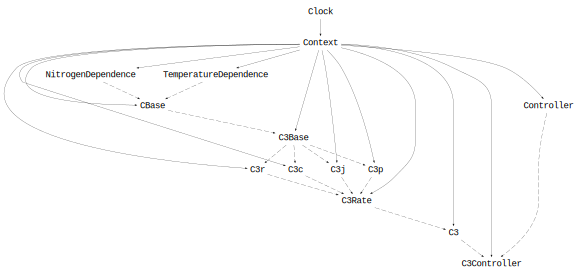

In [21]:
Cropbox.hierarchy(C3Controller)

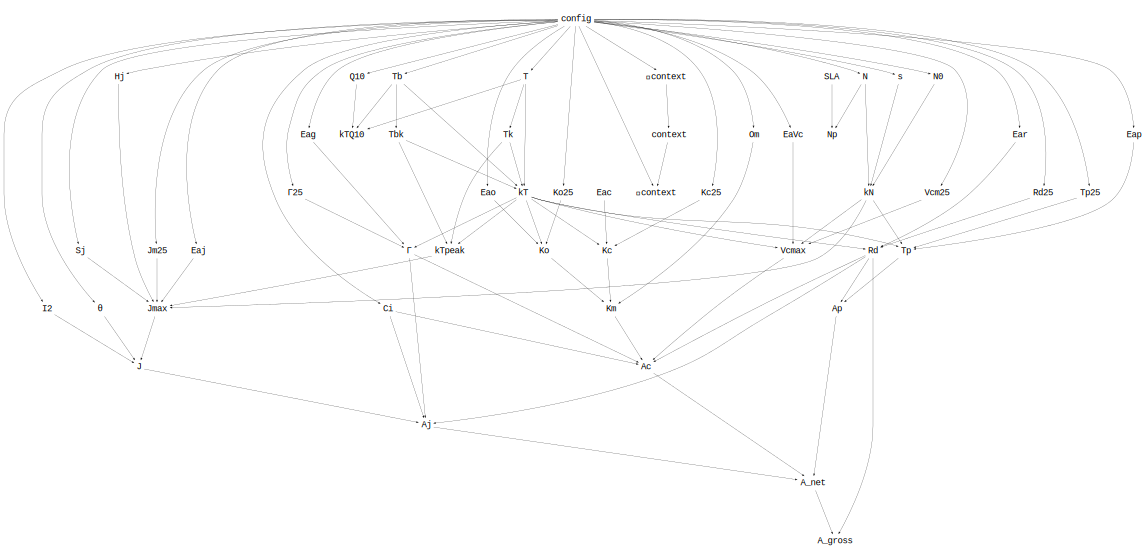

In [22]:
Cropbox.dependency(C3Controller)

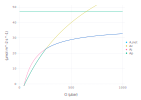

In [23]:
visualize(C3Controller, :Ci, [:A_net, :Ac, :Aj, :Ap];
    xstep = :0 => :Ci => 0:1000,
    ylim = (0,50),
    kind = :line,
)

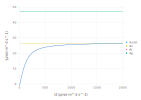

In [24]:
visualize(C3Controller, :I2, [:A_net, :Ac, :Aj, :Ap];
    xstep = :0 => :I2 => 0:2000,
    ylim = (0,50),
    kind = :line,
)

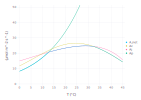

In [25]:
visualize(C3Controller, :T, [:A_net, :Ac, :Aj, :Ap];
    xstep = :0 => :T => 0:45,
    ylim = (0,50),
    kind = :line,
)

### 1.1.3. 엽 - 대기 연결 (interface)

앞에서는 엽 내부에서 일어나는 광합성 반응을 살펴보았고, 이제는 옆 외부와의 상호작용에 대해 알아보겠습니다. 엽과 대기의 경계면(boundary layer), 그리고 기공(stomata)의 여닫음(conductance)에 의해 결정됩니다.

#### 1.1.3.1. 엽 경계면 (boundary layer)

$$
\begin{align}
g_H &= \frac{\mathcal{D}_h \cdot \mathtt{Nu}}{d} \\
\mathtt{Nu} &= 0.60 \sqrt{\mathtt{Re}} \\
\mathtt{Re} &= \frac{u \cdot d}{\mathcal{D}_m} \\
d &= 0.72 w \label{eq:g_H:d} \\
g_h &= g_H \cdot \frac{P_a}{R \cdot T_{a_k}} \\
g_b &= \frac{g_h}{P_a} \cdot {\left( \frac{\mathcal{D}_w}{\mathcal{D}_h} \right)}^{\!\frac{2}{3}} \\
\end{align}
$$

| Symbol | Units | Description |
|:-------|:------|:------------|
$d$ | $\mathrm{m}$ | Leaf characteristic dimension |
$g_b$ | $$\mathrm{mol_{H_2O}}\ \mathrm{m^{-2}}\ \mathrm{s^{-1}}\ \mathrm{bar^{-1}}$$ | Boundary layer conductance to water vapor |
$g_h$ | $\mathrm{mmol}\ \mathrm{m^{-2}}\ \mathrm{s^{-1}}$ | Leaf convective heat conductance in molar flux |
$g_H$ | $\mathrm{m}\ \mathrm{s^{-1}}$ | Leaf convective heat conductance |
$r_{b_c}$ | $\mathrm{m^2}\ \mathrm{s}\ \mathrm{mol^{-1}_{CO_2}}\ \mathrm{bar}$ | Boundary layer resistance to $\mathrm{CO_2}$ |
$u$ | $\mathrm{m}\ \mathrm{s^{-1}}$ | Wind speed |

In [26]:
@system BoundaryLayer(Weather, Diffusion) begin
    w: leaf_width => 10 ~ preserve(u"cm", parameter)

    sr:      stomatal_ratio            => 1.0                       ~ preserve(parameter)
    scr(sr): sides_conductance_ratio   => ((sr + 1)^2 / (sr^2 + 1)) ~ preserve
    ocr:     outdoor_conductance_ratio => 1.4                       ~ preserve

    u(u = wind): wind_velocity                         ~ track(min = 0.1, u"m/s")
    d(w):        characteristic_dimension   => 0.72w   ~ track(u"m")
    v(Dm):       kinematic_viscosity_of_air            ~ preserve(u"m^2/s")
    κ(Dh):       thermal_diffusivity_of_air            ~ preserve(u"m^2/s")
    Re(u, d, v): reynolds_number            => u*d/v   ~ track
    Nu(Re):      nusselt_number             => 0.60√Re ~ track
    gh(κ, Nu, d, scr, ocr, P_air, Tk_air): boundary_layer_heat_conductance => begin
        g = κ * Nu / d
        g *= scr * ocr
        g * P_air / (u"R" * Tk_air)
    end ~ track(u"mmol/m^2/s")

    rhw(Dw, Dh):        ratio_from_heat_to_water_vapor => (Dw / Dh)^(2/3)  ~ preserve
    gb(rhw, gh, P_air): boundary_layer_conductance     => rhw * gh / P_air ~ track(u"mol/m^2/s/bar")
end

BoundaryLayer

#### 1.1.3.2. 기공 (stomata)

##### 1.1.3.2.1. 기공전도도 공통

| Symbol | Units | Description |
|:-------|:------|:------------|
$D_s$ | $\mathrm{kPa}$ | Vapor pressure deficit at the leaf surface |
$f_{\Psi_v}$ | - | Water stress factor |
$g_s$ | $$\mathrm{mol_{H_2O}}\ \mathrm{m^{-2}}\ \mathrm{s^{-1}}\ \mathrm{bar^{-1}}$$ | Stomatal conductance to water vapor |
$g_{s_\textrm{BB}}$ | $\mathrm{mol_{H_2O}}\ \mathrm{m^{-2}}\ \mathrm{s^{-1}}\ \mathrm{bar^{-1}}$ | Stomatal conductance to water vapor from Ball--Berry model |
$g_{s_\textrm{MED}}$ | $\mathrm{mol_{H_2O}}\ \mathrm{m^{-2}}\ \mathrm{s^{-1}}\ \mathrm{bar^{-1}}$ | Stomatal conductance to water vapor from Medlyn model |
$\mathrm{RH}$ | $\mathrm{\%}$ | Relative humidity of the air (0-100) |
$h_a$ | - | Relative humidity of the air (0-1) |
$h_s$ | - | Relative humidity at the leaf surface (0-1) |
$w_a$ | $\mathrm{kPa}$ | Water vapor pressure in the air |
$w_i$ | $\mathrm{kPa}$ | Water vapor pressure in the intercellular space |
$w_s$ | $\mathrm{kPa}$ | Water vapor pressure at the leaf surface |
$\Psi_v$ | $\mathrm{MPa}$ | Bulk leaf water potential |
$r_{s_c}$ | $\mathrm{m^2}\ \mathrm{s}\ \mathrm{mol^{-1}_{CO_2}}\ \mathrm{bar}$ | Stomatal resistance to $\mathrm{CO_2}$ |

| Symbol | Value | Units | Description |
|:-------|:------|:------|:------------|
$\Psi_f$ | -2.0 | $\mathrm{MPa}$ | Reference water potential |
$s_f$ | 2.3 | $\mathrm{MPa}$ | Sensitivity of water response |

$$
C_s = C_a - A_n r_{b_c}
$$

In [27]:
@system StomataBase(Weather, Diffusion) begin
    gs:    stomatal_conductance       ~ hold
    gb:    boundary_layer_conductance ~ hold
    A_net: net_photosynthesis         ~ hold
    T:     leaf_temperature           ~ hold

    drb(Dw, Dc):        diffusivity_ratio_boundary_layer => (Dw / Dc)^(2/3)       ~ preserve
    dra(Dw, Dc):        diffusivity_ratio_air            => (Dw / Dc)             ~ preserve

    Ca(CO2, P_air):     co2_air                          => (CO2 * P_air)         ~ track(u"μbar")
    Cs(Ca, A_net, gbc): co2_at_leaf_surface              => (Ca - A_net / gbc)    ~ track(u"μbar")

    gv(gs, gb):         total_conductance_h2o            => (gs * gb / (gs + gb)) ~ track(u"mol/m^2/s/bar")

    rbc(gb, drb):       boundary_layer_resistance_co2    => (drb / gb)            ~ track(u"m^2*s/mol*bar")
    rsc(gs, dra):       stomatal_resistance_co2          => (dra / gs)            ~ track(u"m^2*s/mol*bar")
    rvc(rbc, rsc):      total_resistance_co2             => (rbc + rsc)           ~ track(u"m^2*s/mol*bar")

    gbc(rbc):           boundary_layer_conductance_co2   => (1 / rbc)             ~ track(u"mol/m^2/s/bar")
    gsc(rsc):           stomatal_conductance_co2         => (1 / rsc)             ~ track(u"mol/m^2/s/bar")
    gvc(rvc):           total_conductance_co2            => (1 / rvc)             ~ track(u"mol/m^2/s/bar")
end

StomataBase

##### 1.1.3.2.2. Tuzet 모형

엽 수분 함량에 따른 기공전도도 변화를 표현하기 위하여 [Tuzet et al. (2003)](https://doi.org/10.1046/j.1365-3040.2003.01035.x)의 수식을 사용합니다.

$$
f_{\Psi_v} = \frac{1 + \exp\!\left[ s_f \Psi_f \right]}{1 + \exp\!\left[ s_f (\Psi_f - \Psi_v) \right]}
$$

In [28]:
@system StomataTuzet begin
    Ψv: leaf_water_potential           => 0    ~ preserve(parameter, u"MPa")
    Ψf: reference_leaf_water_potential => -1.2 ~ preserve(parameter, u"MPa")
    sf: stomata_sensitivity_param      => 2.3  ~ preserve(parameter, u"MPa^-1")
    fΨv(Ψv, Ψf, sf): stomata_sensitivty => begin
        (1 + exp(sf*Ψf)) / (1 + exp(sf*(Ψf-Ψv)))
    end ~ track
end

StomataTuzet

##### 1.1.3.2.3. Ball-Berry 모형

기공전도도(stomatal conductance) 값 자체는 [Ball et al. (1987)](https://doi.org/10.1007/978-94-017-0519-6_48)의 유명한 Ball-Berry 모형을 따릅니다.

$$
g_{s_\textrm{BB}} = g_{0_\textrm{BB}} + g_{1_\textrm{BB}} \frac{h_s A_n}{C_s} f_{\Psi_v}
$$

$$
(h_s - h_a) g_b = (1 - h_s) g_{s_\textrm{BB}}
$$

In [29]:
@system StomataBallBerry(StomataBase, StomataTuzet) begin
    g0 ~ preserve(parameter, u"mol/m^2/s/bar")
    g1 ~ preserve(parameter)

    hs(g0, g1, gb, A_net, Cs, fΨv, RH): relative_humidity_at_leaf_surface => begin
        gs = g0 + g1*(A_net*hs/Cs) * fΨv
        (hs - RH)*gb ⩵ (1 - hs)*gs
    end ~ solve(lower = 0, upper = 1)

    Ds(D = vp.D, T, hs): vapor_pressure_deficit_at_leaf_surface => begin
        D(T, hs)
    end ~ track(u"kPa")

    gs(g0, g1, A_net, hs, Cs, fΨv): stomatal_conductance => begin
        g0 + g1*(A_net*hs/Cs) * fΨv
    end ~ track(min = g0, u"mol/m^2/s/bar")
end

StomataBallBerry

여기서 광합성 모형과의 연결(coupling)을 엽 표면 습도(`hs`)를 풀어내야 합니다. 기존 모형에서는 해당 수식을 손으로 풀어서 그 해를 직접 코딩해주었지만, Cropbox에서는 `solve`라는 패턴의 변수를 사용하여 해당 수식을 넣어주는 것만으로 계산을 대신할 수 있습니다.

##### 1.1.3.2.4. 기공전도도 모형 테스트

Examine how the following individual components of a coupled gas-exchange model are implemented in Cropbox: 2) Ball-Berry model for stomatal conductance.

In [30]:
@system StomataBallBerryController(StomataBallBerry, BoundaryLayer, Controller) begin
    A_net: net_photosynthesis => 40 ~ preserve(parameter, u"μmol/m^2/s")
    T:     leaf_temperature   => 25 ~ preserve(parameter, u"°C")

    g0 => 0.1 ~ preserve(parameter, u"mol/m^2/s/bar")
    g1 => 4.0 ~ preserve(parameter)
end

StomataBallBerryController

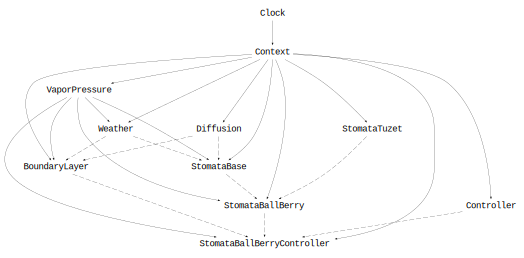

In [31]:
Cropbox.hierarchy(StomataBallBerryController)

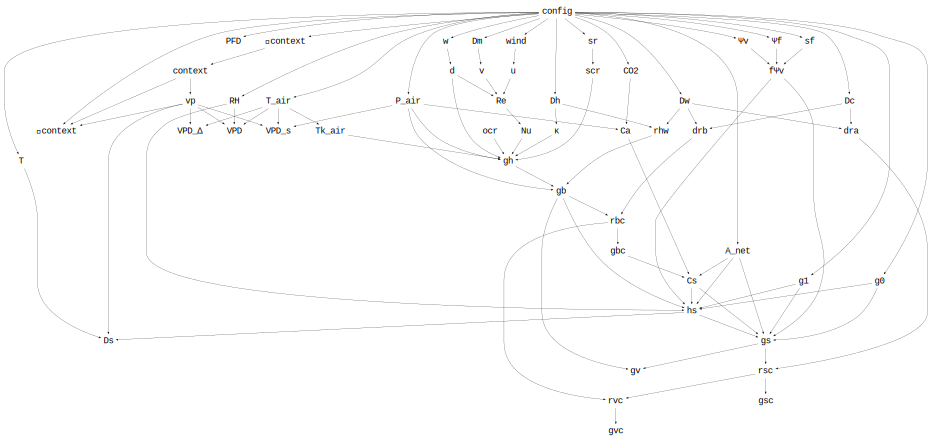

In [32]:
Cropbox.dependency(StomataBallBerryController)

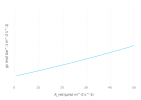

In [33]:
visualize(StomataBallBerryController, :A_net, :gs;
    xstep = :0 => :A_net => 0:50,
    kind = :line,
)

In [34]:
manipulate(StomataBallBerryController, :A_net, :gs;
    parameters = StomataBallBerry => (;
        g0 = 0:0.01:1,
        g1 = 0:0.1:10,
    ),
    xstep = :0 => :A_net => 0:50,
    ylim = (0,2),
    kind = :line,
)

WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any["StomataBallBerry"], Dict{Symbol, Any}(:style => Dict{String, Any}("color" => :darkorchid, "font-family" => "monospace"))), WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[WebIO.Scope(WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :label), Any["g0 (mol bar^-1 m^-2 s^-1)"], Dict{Symbol, Any}(:className => "interact ", :style => Dict{Any, Any}(:padding => "5px 10px 0px 10px", "white-space" => :nowrap, "color" => :royalblue)))], Dict{Symbol, Any}(:className => "interact-flex-row-left")), WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :input), Any[], Dict{Symbol, Any}(:max => 101, :min => 1, :attributes => Dict{Any, Any}(:type => "range", Symbol("data-bind") => "numericValue: index, valueUpdate: 'input', event: {change: function (){this.changes(this.changes()+1)}}", "orient" => "horizontal"), :step => 1, :className => "slider slider is-fullwidth", :style => Dict{Any, Any}()))], Dict{Symbol, Any}(:className => "interact-flex-row-center")), WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :p), Any[], Dict{Symbol, Any}(:attributes => Dict("data-bind" => "text: formatted_val")))], Dict{Symbol, Any}(:className => "interact-flex-row-right"))], Dict{Symbol, Any}(:className => "interact-flex-row interact-widget", :style => Dict("font-family" => "monospace", "width" => "80%"))), Dict{String, Tuple{Observables.AbstractObservable, Union{Nothing, Bool}}}("changes" => (Observable{Int64} with 2 listeners. Value:
0, nothing), "index" => (Observable{Any} with 2 listeners. Value:
51, nothing)), Set{String}(), nothing, WebIO.Asset[WebIO.Asset("js", "knockout", "/opt/julia/packages/Knockout/3gjS1/src/../assets/knockout.js"), WebIO.Asset("js", "knockout_punches", "/opt/julia/packages/Knockout/3gjS1/src/../assets/knockout_punches.js"), WebIO.Asset("js", nothing, "/opt/julia/packages/InteractBase/h8Fwe/src/../assets/all.js"), WebIO.Asset("css", nothing, "/opt/julia/packages/InteractBase/h8Fwe/src/../assets/style.css"), WebIO.Asset("css", nothing, "/opt/julia/packages/Interact/pVyN2/src/../assets/bulma_confined.min.css")], Dict{Any, Any}("changes" => Any[WebIO.JSString("(function (val){return (val!=this.model[\"changes\"]()) ? (this.valueFromJulia[\"changes\"]=true, this.model[\"changes\"](val)) : undefined})")], "index" => Any[WebIO.JSString("(function (val){return (val!=this.model[\"index\"]()) ? (this.valueFromJulia[\"index\"]=true, this.model[\"index\"](val)) : undefined})")]), WebIO.ConnectionPool(Channel{Any}(32), Set{WebIO.AbstractConnection}(), Condition(Base.InvasiveLinkedList{Task}(Task (runnable) @0x00007f98c942b260, Task (runnable) @0x00007f98c942b260), Base.AlwaysLockedST(1))), WebIO.JSString[WebIO.JSString("function () {\n    var handler = (function (ko, koPunches) {\n    ko.punches.enableAll();\n    ko.bindingHandlers.numericValue = {\n        init: function(element, valueAccessor, allBindings, data, context) {\n            var stringified = ko.observable(ko.unwrap(valueAccessor()));\n            stringified.subscribe(function(value) {\n                var val = parseFloat(value);\n                if (!isNaN(val)) {\n                    valueAccessor()(val);\n                }\n            });\n            valueAccessor().subscribe(function(value) {\n                var str = JSON.stringify(value);\n                if ((str == \"0\") && ([\"-0\", \"-0.\"].indexOf(stringified()) >= 0))\n                     return;\n                 if ([\"null\", \"\"].indexOf(str) >= 0)\n                     return;\n                stringified(str);\n            });\n            ko.applyBindingsToNode(\n                element,\n                {\n                    value: stringified,\n                    valueUpdate: allBindings.get('valueUpdate'),\n                },\n          

##### 1.1.3.2.5. Medlyn 모형

최근에는 Ball-Berry 모형을 대신하여 Medlyn 모형을 사용하는 경우도 있습니다. 거의 유사한 구조를 가지고 있지만 습도(증기압)가 극단적으로 높거나 낮은 경우에 보다 자연스러운 결과를 보여줍니다.

$$
g_{s_\textrm{MED}} = g_{0_\textrm{MED}} + \bigg( 1 + \frac{g_{1_\textrm{MED}}}{\sqrt{D_s}} \bigg) \frac{A_n}{C_s} f_{\Psi_v}
$$

$$
(w_s - w_a) g_b = (w_i - w_s) g_{s_\textrm{MED}}
$$

In [35]:
@system StomataMedlyn(StomataBase, StomataTuzet) begin
    g0 ~ preserve(parameter, u"mol/m^2/s/bar")
    g1 ~ preserve(parameter, u"√kPa")

    wa(ea = vp.ea, T_air, RH): vapor_pressure_at_air                 => ea(T_air, RH) ~ track(u"kPa")
    wi(es = vp.es, T):         vapor_pressure_at_intercellular_space => es(T)         ~ track(u"kPa")
    ws(Ds, wi): vapor_pressure_at_leaf_surface                       => (wi - Ds)     ~ track(u"kPa")

    Ds¹ᐟ²(g0, g1, gb, A_net, Cs, fΨv, wi, wa) => begin
        gs = g0 + (1 + g1 / Ds¹ᐟ²) * (A_net / Cs) * fΨv
        ws = wi - Ds¹ᐟ²^2
        (ws - wa)*gb ⩵ (wi - ws)*gs
    end ~ solve(lower = 0, upper = √wi', u"√kPa")
    Ds(Ds¹ᐟ²): vapor_pressure_deficit_at_leaf_surface => Ds¹ᐟ²^2 ~ track(min = 1u"Pa", u"kPa")

    hs(RH = vp.RH, T, Ds): relative_humidity_at_leaf_surface => RH(T, Ds) ~ track

    gs(g0, g1, A_net, Ds, Cs, fΨv): stomatal_conductance => begin
        g0 + (1 + g1/√Ds)*(A_net/Cs) * fΨv
    end ~ track(min = g0, u"mol/m^2/s/bar")
end

StomataMedlyn

#### 1.1.3.3. 세포 사이 공간 (intercellular space)

기본적으로 광합성과 기공전도도의 연결(coupling)은 비선형적(nonlinear)이기 때문에 일반해(analytic solution)를 구하기 쉽지 않습니다. 쉽게 얘기해서 광합성(`A_net`)은 엽 내부의 $\mathrm{CO_2}$ 농도(`Ci`)에 의해 좌우되며, $\mathrm{CO_2}$ 농도는 기공전도도(`gs`)에 의해 조절됩니다. 그런데 이 기공전도도는 대부분의 모형에서 광합성(`A_net`)과의 경험적인(empirical) 관계로 기술되고 있습니다. 즉, 서로 물고 물리는 관계가 되어 한번에 값을 찾아내기 어려운 것이지요. 그래서 수치적인(numerical) 방법을 이용하여 해를 반복적으로 구하여 가장 근사한 값을 찾아내는 과정을 수행하게 됩니다.

Cropbox에서는 단순하지만 다양한 경우에 적용이 가능한 이분법(bisection method)을 기본 제공하고, 위에서 `Ci` 값을 찾는데 활용하는 것을 볼 수 있습니다.

$$
\begin{align}
C_m \approx C_i &= C_a - \frac{A_n}{g_{v_c}} \\
g_{v_c} &= \frac{1}{r_{v_c}} \\
r_{v_c} &= r_{s_c} + r_{b_c} \\
r_{s_c} &= \frac{1}{g_s} \cdot {\left( \frac{\mathcal{D}_w}{\mathcal{D}_c} \right)}^{\!1}  \\
r_{b_c} &= \frac{1}{g_b} \cdot {\left( \frac{\mathcal{D}_w}{\mathcal{D}_c} \right)}^{\!\frac{2}{3}}
\end{align}
$$

In [36]:
@system IntercellularSpace(Weather) begin
    A_net ~ hold
    gvc   ~ hold

    Ca(CO2, P_air): co2_air                       => (CO2 * P_air) ~ track(u"μbar")
    Cimax(Ca):      intercellular_co2_upper_limit => 2Ca           ~ track(u"μbar")
    Cimin:          intercellular_co2_lower_limit => 0             ~ preserve(u"μbar")
    Ci(Ca, Ci, A_net, gvc): intercellular_co2 => begin
        Ca - Ci ⩵ A_net / gvc
    end ~ bisect(min = Cimin, upper = Cimax, u"μbar")
end

IntercellularSpace

### 1.1.4. 에너지 균형 (energy balance)

광합성은 태양광을 이용하여 이루어지며, 이에 수반하는 태양 복사 에너지에 의해 엽온 또한 함께 올라갈 수 있습니다. 그런데 여타 생화학 반응처럼 광합성 역시 Rubisco 효소의 작용에 기반하기 때문에 주변 온도에 민감합니다. 즉, 엽온의 변화에 따라 광합성 효율이 달라질 수 있는 것입니다. 추가적으로 기공이 열리면 이를 통해 이산화탄소($\mathrm{CO_2}$)를 흡수하는 동시에 반대급부적으로 수증기($\mathrm{H_2O}$)의 유출 또한 발생합니다. 이러한 수분의 증산(transpiration) 과정에서 주변의 열 에너지를 흡수하기 때문에 결과적으로 엽온을 낮춰주는 효과를 가지고 있습니다. 이렇게 열 에너지, 그리고 이로 인해 결정되는 엽온과 관련하여 서로 맞물린 관계를 표현하는 것이 에너지 균형(energy balance) 방정식입니다.

$$
T_l = T_a + \Delta T
$$

$$
R_n - H - \lambda E = 0
$$

$$
\begin{align}
R_n &= R_{sw} + R_{lw} \\
R_{sw} &= \alpha_s k I \\
R_{lw} &= 2 \epsilon \sigma (T_{a_k}^4 - T_{l_k}^4)
\end{align}
$$

$$
H = C_p g_h \Delta T
$$

$$
\begin{align}
E &= g_v \Delta w \\
g_v &= \frac{1}{\cfrac{1}{g_s} + \cfrac{1}{g_b}} \\
D &= e_s[T_l] - e_a
\end{align}
$$

| Symbol | Units | Description |
|:-------|:------|:------------|
$\Delta w$ | $\mathrm{kPa}$ | Vapor pressure gradient between leaf surface and the air |
$e_a$ | $\mathrm{kPa}$ | Vapor pressure in the ambient air |
$e_s$ | $\mathrm{kPa}$ | Saturated vapor pressure |
$E$ | $\mathrm{mmol_{H_2O}}\ \mathrm{m^{-2}}\ \mathrm{s^{-1}}$ | Transpiration rate |
$g_v$ | $$\mathrm{mol_{H_2O}}\ \mathrm{m^{-2}}\ \mathrm{s^{-1}}\ \mathrm{bar^{-1}}$$ | Total leaf conductance to water vapor |
$H$ | $\mathrm{W}\ \mathrm{m^{-2}}$ | Sensible heat flux |
$\lambda E$ | $\mathrm{W}\ \mathrm{m^{-2}}$ | Latent heat flux |
$R_n$ | $\mathrm{W}\ \mathrm{m^{-2}}$ | Net radiation absorbed |
$\Delta T$ | $\mathrm{K}$ | Temperature difference between $T_l$ and $T_a$ |

| Symbol | Value | Units | Description |
|:-------|:------|:------|:------------|
$\alpha_s$ | 0.79 | - | Radiation absorption coefficient of the leaf |
$C_p$ | 29.3 | $\mathrm{J}\ \mathrm{mol^{-1}}\ \mathrm{K^{-1}}$ | Specific heat of air |
$\epsilon$ | 0.97 | - | Leaf thermal emissivity |
$k$ | 0.22 | $\mathrm{J}\ \mathrm{\mu mol^{-1}}$ | Radiation conversion factor |
$\lambda$ | 44 | $\mathrm{kJ}\ \mathrm{mol^{-1}}$ | Latent heat of vaporization at 25 $\mathrm{^{\circ}C}$ |
$\sigma$ | $$5.670 \times 10^{-8}$$ | $$\mathrm{W}\ \mathrm{m^{-2}}\ \mathrm{K^{-4}}$$ | Stefan-Boltzmann constant |

In [37]:
@system EnergyBalance(Weather) begin
    gv ~ hold
    gh ~ hold
    PPFD ~ hold

    ϵ:  leaf_thermal_emissivity           => 0.97 ~ preserve(parameter)
    σ:  stefan_boltzmann_constant         => u"σ" ~ preserve(u"W/m^2/K^4")
    λ:  latent_heat_of_vaporization_at_25 => 44   ~ preserve(parameter, u"kJ/mol")
    Cp: specific_heat_of_air              => 29.3 ~ preserve(parameter, u"J/mol/K")

    k:              radiation_conversion_factor         => (1 / 4.55)   ~ preserve(u"J/μmol")
    α_s:            absorption_coefficient              => 0.79         ~ preserve(parameter)
    PAR(PPFD, k):   photosynthetically_active_radiation => (PPFD * k)   ~ track(u"W/m^2")
    R_sw(PAR, α_s): shortwave_radiation_absorbed        => (α_s * PAR) ~ track(u"W/m^2")

    R_wall(ϵ, σ, Tk_air):      thermal_radiation_absorbed_from_wall => 2ϵ*σ*Tk_air^4    ~ track(u"W/m^2")
    R_leaf(ϵ, σ, Tk):          thermal_radiation_emitted_by_leaf    => 2ϵ*σ*Tk^4        ~ track(u"W/m^2")
    R_thermal(R_wall, R_leaf): thermal_radiation_absorbed           => R_wall - R_leaf  ~ track(u"W/m^2")
    R_net(R_sw, R_thermal):    net_radiation_absorbed               => R_sw + R_thermal ~ track(u"W/m^2")

    Δw(T, T_air, RH, ea = vp.ambient, es = vp.saturation): leaf_vapor_pressure_gradient => begin
        es(T) - ea(T_air, RH)
    end ~ track(u"kPa")
    E(gv, Δw): transpiration => gv*Δw ~ track(u"mmol/m^2/s")

    H(Cp, gh, ΔT): sensible_heat_flux => Cp*gh*ΔT ~ track(u"W/m^2")
    λE(λ, E):      latent_heat_flux   => λ*E      ~ track(u"W/m^2")

    ΔT(R_net, H, λE): temperature_adjustment => begin
        R_net ⩵ H + λE
    end ~ bisect(lower = -10, upper = 10, u"K", evalunit = u"W/m^2")

    T(T_air, ΔT): leaf_temperature          => (T_air + ΔT) ~ track(u"°C")
    Tk(T):        absolute_leaf_temperature                 ~ track(u"K")
end

EnergyBalance

에너지 균형 방정식 역시 일반해를 구하기 쉽지는 않지만, 여기서는 `bisect` 변수를 이용하여 $R_n - H - \lambda E = 0$ 방정식을 그대로 넣어주는 것만으로 엽온 변화(`ΔT`)를 계산하고 있습니다.

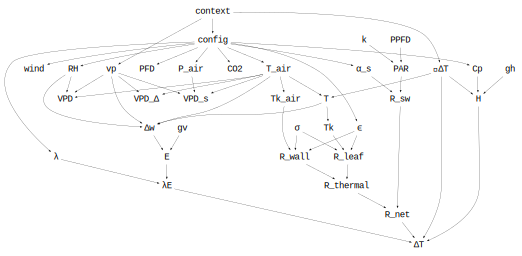

In [38]:
Cropbox.dependency(EnergyBalance)

#### 1.1.4.1. 에너지 균형 테스트

In [39]:
@system EnergyBalanceController(EnergyBalance, Controller) begin
    gv: total_conductance_h2o                        ~ preserve(parameter, u"mol/m^2/s/bar")
    gh: boundary_layer_heat_conductance      => 2000 ~ preserve(parameter, u"mmol/m^2/s")
    PPFD: photosynthetic_photon_flux_density         ~ preserve(parameter, u"μmol/m^2/s")
end

EnergyBalanceController

In [40]:
manipulate(EnergyBalanceController, :PPFD, :ΔT;
    parameters = :0 => (;
        gv = 0:0.1:1,
    ),
    xstep = :0 => :PPFD => 0:10:2000,
    ylim = (-5,5),
    kind = :line,
)

WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any["0"], Dict{Symbol, Any}(:style => Dict{String, Any}("color" => :darkorchid, "font-family" => "monospace"))), WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[WebIO.Scope(WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :label), Any["gv"], Dict{Symbol, Any}(:className => "interact ", :style => Dict{Any, Any}(:padding => "5px 10px 0px 10px", "white-space" => :nowrap, "color" => :royalblue)))], Dict{Symbol, Any}(:className => "interact-flex-row-left")), WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :input), Any[], Dict{Symbol, Any}(:max => 11, :min => 1, :attributes => Dict{Any, Any}(:type => "range", Symbol("data-bind") => "numericValue: index, valueUpdate: 'input', event: {change: function (){this.changes(this.changes()+1)}}", "orient" => "horizontal"), :step => 1, :className => "slider slider is-fullwidth", :style => Dict{Any, Any}()))], Dict{Symbol, Any}(:className => "interact-flex-row-center")), WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :p), Any[], Dict{Symbol, Any}(:attributes => Dict("data-bind" => "text: formatted_val")))], Dict{Symbol, Any}(:className => "interact-flex-row-right"))], Dict{Symbol, Any}(:className => "interact-flex-row interact-widget", :style => Dict("font-family" => "monospace", "width" => "80%"))), Dict{String, Tuple{Observables.AbstractObservable, Union{Nothing, Bool}}}("changes" => (Observable{Int64} with 2 listeners. Value:
0, nothing), "index" => (Observable{Any} with 2 listeners. Value:
6, nothing)), Set{String}(), nothing, WebIO.Asset[WebIO.Asset("js", "knockout", "/opt/julia/packages/Knockout/3gjS1/src/../assets/knockout.js"), WebIO.Asset("js", "knockout_punches", "/opt/julia/packages/Knockout/3gjS1/src/../assets/knockout_punches.js"), WebIO.Asset("js", nothing, "/opt/julia/packages/InteractBase/h8Fwe/src/../assets/all.js"), WebIO.Asset("css", nothing, "/opt/julia/packages/InteractBase/h8Fwe/src/../assets/style.css"), WebIO.Asset("css", nothing, "/opt/julia/packages/Interact/pVyN2/src/../assets/bulma_confined.min.css")], Dict{Any, Any}("changes" => Any[WebIO.JSString("(function (val){return (val!=this.model[\"changes\"]()) ? (this.valueFromJulia[\"changes\"]=true, this.model[\"changes\"](val)) : undefined})")], "index" => Any[WebIO.JSString("(function (val){return (val!=this.model[\"index\"]()) ? (this.valueFromJulia[\"index\"]=true, this.model[\"index\"](val)) : undefined})")]), WebIO.ConnectionPool(Channel{Any}(32), Set{WebIO.AbstractConnection}(), Condition(Base.InvasiveLinkedList{Task}(Task (runnable) @0x00007f98b6afb260, Task (runnable) @0x00007f98b6afb260), Base.AlwaysLockedST(1))), WebIO.JSString[WebIO.JSString("function () {\n    var handler = (function (ko, koPunches) {\n    ko.punches.enableAll();\n    ko.bindingHandlers.numericValue = {\n        init: function(element, valueAccessor, allBindings, data, context) {\n            var stringified = ko.observable(ko.unwrap(valueAccessor()));\n            stringified.subscribe(function(value) {\n                var val = parseFloat(value);\n                if (!isNaN(val)) {\n                    valueAccessor()(val);\n                }\n            });\n            valueAccessor().subscribe(function(value) {\n                var str = JSON.stringify(value);\n                if ((str == \"0\") && ([\"-0\", \"-0.\"].indexOf(stringified()) >= 0))\n                     return;\n                 if ([\"null\", \"\"].indexOf(str) >= 0)\n                     return;\n                stringified(str);\n            });\n            ko.applyBindingsToNode(\n                element,\n                {\n                    value: stringified,\n                    valueUpdate: allBindings.get('valueUpdate'),\n                },\n                context,\n            );\n        

### 1.1.5. 모형 결합 (coupling)

In [41]:
@system GasExchange(Weather, BoundaryLayer, StomataBase, IntercellularSpace, Irradiance, EnergyBalance)

GasExchange

In [42]:
@system C3BB(GasExchange, StomataBallBerry, C3, Controller) begin
    g0 => 0.096 ~ preserve(parameter, u"mol/m^2/s/bar")
    g1 => 6.824 ~ preserve(parameter)
end

C3BB

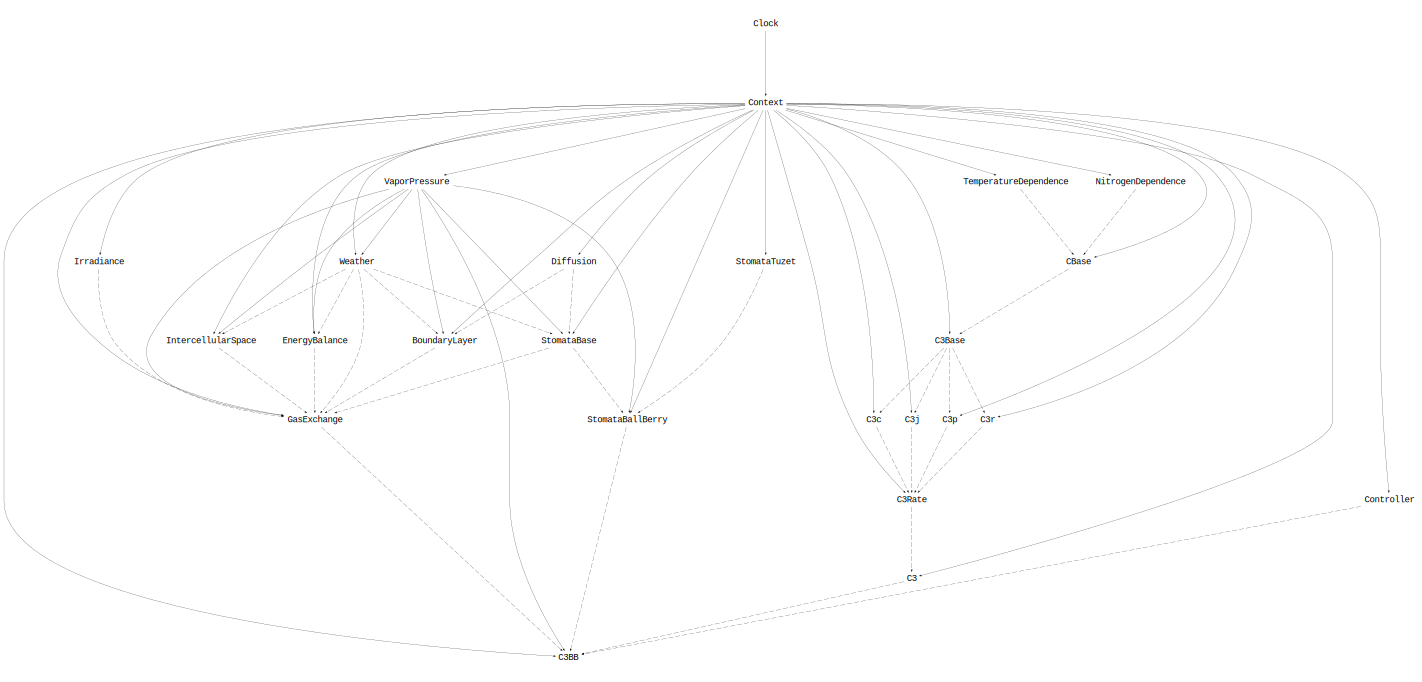

In [43]:
Cropbox.hierarchy(C3BB)

## 1.2. 모형 구동

In [44]:
weather_config = parameters(Weather)

Config for 1 system:
  Weather
    PFD   = 2000 μmol m^-2 s^-1
    CO2   = 400 μmol mol^-1
    RH    = 66 %
    T_air = 32 °C
    wind  = 2.0 m s^-1
    P_air = 99.4 kPa

### 1.2.1. C3 광합성

#### 1.2.1.1. A-Ci 곡선

In [45]:
manipulate(C3BB, :Ci, [:A_net, :Ac, :Aj, :Ap];
    config = weather_config,
    parameters = Weather => (;
        PFD = 0:10:3000,
        T_air = -10:45,
    ),
    xstep = Weather => :CO2 => 10:10:1500,
    ylim = (0,40),
    kind = :line,
)

WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any["Weather"], Dict{Symbol, Any}(:style => Dict{String, Any}("color" => :darkorchid, "font-family" => "monospace"))), WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[WebIO.Scope(WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :label), Any["PFD (μmol m^-2 s^-1)"], Dict{Symbol, Any}(:className => "interact ", :style => Dict{Any, Any}(:padding => "5px 10px 0px 10px", "white-space" => :nowrap, "color" => :royalblue)))], Dict{Symbol, Any}(:className => "interact-flex-row-left")), WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :input), Any[], Dict{Symbol, Any}(:max => 301, :min => 1, :attributes => Dict{Any, Any}(:type => "range", Symbol("data-bind") => "numericValue: index, valueUpdate: 'input', event: {change: function (){this.changes(this.changes()+1)}}", "orient" => "horizontal"), :step => 1, :className => "slider slider is-fullwidth", :style => Dict{Any, Any}()))], Dict{Symbol, Any}(:className => "interact-flex-row-center")), WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :p), Any[], Dict{Symbol, Any}(:attributes => Dict("data-bind" => "text: formatted_val")))], Dict{Symbol, Any}(:className => "interact-flex-row-right"))], Dict{Symbol, Any}(:className => "interact-flex-row interact-widget", :style => Dict("font-family" => "monospace", "width" => "80%"))), Dict{String, Tuple{Observables.AbstractObservable, Union{Nothing, Bool}}}("changes" => (Observable{Int64} with 2 listeners. Value:
0, nothing), "index" => (Observable{Any} with 2 listeners. Value:
201, nothing)), Set{String}(), nothing, WebIO.Asset[WebIO.Asset("js", "knockout", "/opt/julia/packages/Knockout/3gjS1/src/../assets/knockout.js"), WebIO.Asset("js", "knockout_punches", "/opt/julia/packages/Knockout/3gjS1/src/../assets/knockout_punches.js"), WebIO.Asset("js", nothing, "/opt/julia/packages/InteractBase/h8Fwe/src/../assets/all.js"), WebIO.Asset("css", nothing, "/opt/julia/packages/InteractBase/h8Fwe/src/../assets/style.css"), WebIO.Asset("css", nothing, "/opt/julia/packages/Interact/pVyN2/src/../assets/bulma_confined.min.css")], Dict{Any, Any}("changes" => Any[WebIO.JSString("(function (val){return (val!=this.model[\"changes\"]()) ? (this.valueFromJulia[\"changes\"]=true, this.model[\"changes\"](val)) : undefined})")], "index" => Any[WebIO.JSString("(function (val){return (val!=this.model[\"index\"]()) ? (this.valueFromJulia[\"index\"]=true, this.model[\"index\"](val)) : undefined})")]), WebIO.ConnectionPool(Channel{Any}(32), Set{WebIO.AbstractConnection}(), Condition(Base.InvasiveLinkedList{Task}(Task (runnable) @0x00007f98c9296400, Task (runnable) @0x00007f98c9296400), Base.AlwaysLockedST(1))), WebIO.JSString[WebIO.JSString("function () {\n    var handler = (function (ko, koPunches) {\n    ko.punches.enableAll();\n    ko.bindingHandlers.numericValue = {\n        init: function(element, valueAccessor, allBindings, data, context) {\n            var stringified = ko.observable(ko.unwrap(valueAccessor()));\n            stringified.subscribe(function(value) {\n                var val = parseFloat(value);\n                if (!isNaN(val)) {\n                    valueAccessor()(val);\n                }\n            });\n            valueAccessor().subscribe(function(value) {\n                var str = JSON.stringify(value);\n                if ((str == \"0\") && ([\"-0\", \"-0.\"].indexOf(stringified()) >= 0))\n                     return;\n                 if ([\"null\", \"\"].indexOf(str) >= 0)\n                     return;\n                stringified(str);\n            });\n            ko.applyBindingsToNode(\n                element,\n                {\n                    value: stringified,\n                    valueUpdate: allBindings.get('valueUpdate'),\n                },\n                context

#### 1.2.1.2. A-Q

In [46]:
manipulate(C3BB, :PFD, [:A_net, :Ac, :Aj, :Ap];
    config = weather_config,
    parameters = Weather => (;
        CO2 = 10:10:1500,
        T_air = -10:45,
    ),
    xstep = Weather => :PFD => 0:20:2000,
    ylim = (0,40),
    kind = :line,
)

WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any["Weather"], Dict{Symbol, Any}(:style => Dict{String, Any}("color" => :darkorchid, "font-family" => "monospace"))), WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[WebIO.Scope(WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :label), Any["CO2 (μmol mol^-1)"], Dict{Symbol, Any}(:className => "interact ", :style => Dict{Any, Any}(:padding => "5px 10px 0px 10px", "white-space" => :nowrap, "color" => :royalblue)))], Dict{Symbol, Any}(:className => "interact-flex-row-left")), WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :input), Any[], Dict{Symbol, Any}(:max => 150, :min => 1, :attributes => Dict{Any, Any}(:type => "range", Symbol("data-bind") => "numericValue: index, valueUpdate: 'input', event: {change: function (){this.changes(this.changes()+1)}}", "orient" => "horizontal"), :step => 1, :className => "slider slider is-fullwidth", :style => Dict{Any, Any}()))], Dict{Symbol, Any}(:className => "interact-flex-row-center")), WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :p), Any[], Dict{Symbol, Any}(:attributes => Dict("data-bind" => "text: formatted_val")))], Dict{Symbol, Any}(:className => "interact-flex-row-right"))], Dict{Symbol, Any}(:className => "interact-flex-row interact-widget", :style => Dict("font-family" => "monospace", "width" => "80%"))), Dict{String, Tuple{Observables.AbstractObservable, Union{Nothing, Bool}}}("changes" => (Observable{Int64} with 2 listeners. Value:
0, nothing), "index" => (Observable{Any} with 2 listeners. Value:
40, nothing)), Set{String}(), nothing, WebIO.Asset[WebIO.Asset("js", "knockout", "/opt/julia/packages/Knockout/3gjS1/src/../assets/knockout.js"), WebIO.Asset("js", "knockout_punches", "/opt/julia/packages/Knockout/3gjS1/src/../assets/knockout_punches.js"), WebIO.Asset("js", nothing, "/opt/julia/packages/InteractBase/h8Fwe/src/../assets/all.js"), WebIO.Asset("css", nothing, "/opt/julia/packages/InteractBase/h8Fwe/src/../assets/style.css"), WebIO.Asset("css", nothing, "/opt/julia/packages/Interact/pVyN2/src/../assets/bulma_confined.min.css")], Dict{Any, Any}("changes" => Any[WebIO.JSString("(function (val){return (val!=this.model[\"changes\"]()) ? (this.valueFromJulia[\"changes\"]=true, this.model[\"changes\"](val)) : undefined})")], "index" => Any[WebIO.JSString("(function (val){return (val!=this.model[\"index\"]()) ? (this.valueFromJulia[\"index\"]=true, this.model[\"index\"](val)) : undefined})")]), WebIO.ConnectionPool(Channel{Any}(32), Set{WebIO.AbstractConnection}(), Condition(Base.InvasiveLinkedList{Task}(Task (runnable) @0x00007f98b6b22ca0, Task (runnable) @0x00007f98b6b22ca0), Base.AlwaysLockedST(1))), WebIO.JSString[WebIO.JSString("function () {\n    var handler = (function (ko, koPunches) {\n    ko.punches.enableAll();\n    ko.bindingHandlers.numericValue = {\n        init: function(element, valueAccessor, allBindings, data, context) {\n            var stringified = ko.observable(ko.unwrap(valueAccessor()));\n            stringified.subscribe(function(value) {\n                var val = parseFloat(value);\n                if (!isNaN(val)) {\n                    valueAccessor()(val);\n                }\n            });\n            valueAccessor().subscribe(function(value) {\n                var str = JSON.stringify(value);\n                if ((str == \"0\") && ([\"-0\", \"-0.\"].indexOf(stringified()) >= 0))\n                     return;\n                 if ([\"null\", \"\"].indexOf(str) >= 0)\n                     return;\n                stringified(str);\n            });\n            ko.applyBindingsToNode(\n                element,\n                {\n                    value: stringified,\n                    valueUpdate: allBindings.get('valueUpdate'),\n                },\n                context,\n 

#### 1.2.1.3. A-T 곡선

In [47]:
manipulate(C3BB, :T_air, [:A_net, :Ac, :Aj, :Ap];
    config = weather_config,
    parameters = Weather => (;
        CO2 = 10:10:1500,
        PFD = 0:10:3000,
    ),
    xstep = Weather => :T_air => 0:45,
    ylim = (0,40),
    kind = :line,
)

WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any["Weather"], Dict{Symbol, Any}(:style => Dict{String, Any}("color" => :darkorchid, "font-family" => "monospace"))), WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[WebIO.Scope(WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :label), Any["CO2 (μmol mol^-1)"], Dict{Symbol, Any}(:className => "interact ", :style => Dict{Any, Any}(:padding => "5px 10px 0px 10px", "white-space" => :nowrap, "color" => :royalblue)))], Dict{Symbol, Any}(:className => "interact-flex-row-left")), WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :input), Any[], Dict{Symbol, Any}(:max => 150, :min => 1, :attributes => Dict{Any, Any}(:type => "range", Symbol("data-bind") => "numericValue: index, valueUpdate: 'input', event: {change: function (){this.changes(this.changes()+1)}}", "orient" => "horizontal"), :step => 1, :className => "slider slider is-fullwidth", :style => Dict{Any, Any}()))], Dict{Symbol, Any}(:className => "interact-flex-row-center")), WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :p), Any[], Dict{Symbol, Any}(:attributes => Dict("data-bind" => "text: formatted_val")))], Dict{Symbol, Any}(:className => "interact-flex-row-right"))], Dict{Symbol, Any}(:className => "interact-flex-row interact-widget", :style => Dict("font-family" => "monospace", "width" => "80%"))), Dict{String, Tuple{Observables.AbstractObservable, Union{Nothing, Bool}}}("changes" => (Observable{Int64} with 2 listeners. Value:
0, nothing), "index" => (Observable{Any} with 2 listeners. Value:
40, nothing)), Set{String}(), nothing, WebIO.Asset[WebIO.Asset("js", "knockout", "/opt/julia/packages/Knockout/3gjS1/src/../assets/knockout.js"), WebIO.Asset("js", "knockout_punches", "/opt/julia/packages/Knockout/3gjS1/src/../assets/knockout_punches.js"), WebIO.Asset("js", nothing, "/opt/julia/packages/InteractBase/h8Fwe/src/../assets/all.js"), WebIO.Asset("css", nothing, "/opt/julia/packages/InteractBase/h8Fwe/src/../assets/style.css"), WebIO.Asset("css", nothing, "/opt/julia/packages/Interact/pVyN2/src/../assets/bulma_confined.min.css")], Dict{Any, Any}("changes" => Any[WebIO.JSString("(function (val){return (val!=this.model[\"changes\"]()) ? (this.valueFromJulia[\"changes\"]=true, this.model[\"changes\"](val)) : undefined})")], "index" => Any[WebIO.JSString("(function (val){return (val!=this.model[\"index\"]()) ? (this.valueFromJulia[\"index\"]=true, this.model[\"index\"](val)) : undefined})")]), WebIO.ConnectionPool(Channel{Any}(32), Set{WebIO.AbstractConnection}(), Condition(Base.InvasiveLinkedList{Task}(Task (runnable) @0x00007f98b2fc26e0, Task (runnable) @0x00007f98b2fc26e0), Base.AlwaysLockedST(1))), WebIO.JSString[WebIO.JSString("function () {\n    var handler = (function (ko, koPunches) {\n    ko.punches.enableAll();\n    ko.bindingHandlers.numericValue = {\n        init: function(element, valueAccessor, allBindings, data, context) {\n            var stringified = ko.observable(ko.unwrap(valueAccessor()));\n            stringified.subscribe(function(value) {\n                var val = parseFloat(value);\n                if (!isNaN(val)) {\n                    valueAccessor()(val);\n                }\n            });\n            valueAccessor().subscribe(function(value) {\n                var str = JSON.stringify(value);\n                if ((str == \"0\") && ([\"-0\", \"-0.\"].indexOf(stringified()) >= 0))\n                     return;\n                 if ([\"null\", \"\"].indexOf(str) >= 0)\n                     return;\n                stringified(str);\n            });\n            ko.applyBindingsToNode(\n                element,\n                {\n                    value: stringified,\n                    valueUpdate: allBindings.get('valueUpdate'),\n                },\n                context,\n 

#### 1.2.1.4. 질소 반응

In [48]:
manipulate(C3BB, :Np, :A_net;
    config = weather_config,
    parameters = Weather => (;
        PFD = 0:10:3000,
        T_air = -10:45,
    ),
    xstep = NitrogenDependence => :N => 0.5:0.01:2.0,
    group = Weather => :CO2 => [1000, 400, 250],
    ylim = (0,40),
    kind = :line,
)

WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any["Weather"], Dict{Symbol, Any}(:style => Dict{String, Any}("color" => :darkorchid, "font-family" => "monospace"))), WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[WebIO.Scope(WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :label), Any["PFD (μmol m^-2 s^-1)"], Dict{Symbol, Any}(:className => "interact ", :style => Dict{Any, Any}(:padding => "5px 10px 0px 10px", "white-space" => :nowrap, "color" => :royalblue)))], Dict{Symbol, Any}(:className => "interact-flex-row-left")), WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :input), Any[], Dict{Symbol, Any}(:max => 301, :min => 1, :attributes => Dict{Any, Any}(:type => "range", Symbol("data-bind") => "numericValue: index, valueUpdate: 'input', event: {change: function (){this.changes(this.changes()+1)}}", "orient" => "horizontal"), :step => 1, :className => "slider slider is-fullwidth", :style => Dict{Any, Any}()))], Dict{Symbol, Any}(:className => "interact-flex-row-center")), WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :p), Any[], Dict{Symbol, Any}(:attributes => Dict("data-bind" => "text: formatted_val")))], Dict{Symbol, Any}(:className => "interact-flex-row-right"))], Dict{Symbol, Any}(:className => "interact-flex-row interact-widget", :style => Dict("font-family" => "monospace", "width" => "80%"))), Dict{String, Tuple{Observables.AbstractObservable, Union{Nothing, Bool}}}("changes" => (Observable{Int64} with 2 listeners. Value:
0, nothing), "index" => (Observable{Any} with 2 listeners. Value:
201, nothing)), Set{String}(), nothing, WebIO.Asset[WebIO.Asset("js", "knockout", "/opt/julia/packages/Knockout/3gjS1/src/../assets/knockout.js"), WebIO.Asset("js", "knockout_punches", "/opt/julia/packages/Knockout/3gjS1/src/../assets/knockout_punches.js"), WebIO.Asset("js", nothing, "/opt/julia/packages/InteractBase/h8Fwe/src/../assets/all.js"), WebIO.Asset("css", nothing, "/opt/julia/packages/InteractBase/h8Fwe/src/../assets/style.css"), WebIO.Asset("css", nothing, "/opt/julia/packages/Interact/pVyN2/src/../assets/bulma_confined.min.css")], Dict{Any, Any}("changes" => Any[WebIO.JSString("(function (val){return (val!=this.model[\"changes\"]()) ? (this.valueFromJulia[\"changes\"]=true, this.model[\"changes\"](val)) : undefined})")], "index" => Any[WebIO.JSString("(function (val){return (val!=this.model[\"index\"]()) ? (this.valueFromJulia[\"index\"]=true, this.model[\"index\"](val)) : undefined})")]), WebIO.ConnectionPool(Channel{Any}(32), Set{WebIO.AbstractConnection}(), Condition(Base.InvasiveLinkedList{Task}(Task (runnable) @0x00007f98b2fc0010, Task (runnable) @0x00007f98b2fc0010), Base.AlwaysLockedST(1))), WebIO.JSString[WebIO.JSString("function () {\n    var handler = (function (ko, koPunches) {\n    ko.punches.enableAll();\n    ko.bindingHandlers.numericValue = {\n        init: function(element, valueAccessor, allBindings, data, context) {\n            var stringified = ko.observable(ko.unwrap(valueAccessor()));\n            stringified.subscribe(function(value) {\n                var val = parseFloat(value);\n                if (!isNaN(val)) {\n                    valueAccessor()(val);\n                }\n            });\n            valueAccessor().subscribe(function(value) {\n                var str = JSON.stringify(value);\n                if ((str == \"0\") && ([\"-0\", \"-0.\"].indexOf(stringified()) >= 0))\n                     return;\n                 if ([\"null\", \"\"].indexOf(str) >= 0)\n                     return;\n                stringified(str);\n            });\n            ko.applyBindingsToNode(\n                element,\n                {\n                    value: stringified,\n                    valueUpdate: allBindings.get('valueUpdate'),\n                },\n                context

In [49]:
manipulate(C3BB, :T_air, :A_net;
    config = weather_config,
    parameters = Weather => (;
        CO2 = 10:10:1500,
        PFD = 0:10:3000,
    ),
    xstep = Weather => :T_air => 0:45,
    group = NitrogenDependence => :N => 2:-0.5:0.5,
    ylim = (0,40),
    kind = :line,
)

WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any["Weather"], Dict{Symbol, Any}(:style => Dict{String, Any}("color" => :darkorchid, "font-family" => "monospace"))), WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[WebIO.Scope(WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :label), Any["CO2 (μmol mol^-1)"], Dict{Symbol, Any}(:className => "interact ", :style => Dict{Any, Any}(:padding => "5px 10px 0px 10px", "white-space" => :nowrap, "color" => :royalblue)))], Dict{Symbol, Any}(:className => "interact-flex-row-left")), WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :input), Any[], Dict{Symbol, Any}(:max => 150, :min => 1, :attributes => Dict{Any, Any}(:type => "range", Symbol("data-bind") => "numericValue: index, valueUpdate: 'input', event: {change: function (){this.changes(this.changes()+1)}}", "orient" => "horizontal"), :step => 1, :className => "slider slider is-fullwidth", :style => Dict{Any, Any}()))], Dict{Symbol, Any}(:className => "interact-flex-row-center")), WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :p), Any[], Dict{Symbol, Any}(:attributes => Dict("data-bind" => "text: formatted_val")))], Dict{Symbol, Any}(:className => "interact-flex-row-right"))], Dict{Symbol, Any}(:className => "interact-flex-row interact-widget", :style => Dict("font-family" => "monospace", "width" => "80%"))), Dict{String, Tuple{Observables.AbstractObservable, Union{Nothing, Bool}}}("changes" => (Observable{Int64} with 2 listeners. Value:
0, nothing), "index" => (Observable{Any} with 2 listeners. Value:
40, nothing)), Set{String}(), nothing, WebIO.Asset[WebIO.Asset("js", "knockout", "/opt/julia/packages/Knockout/3gjS1/src/../assets/knockout.js"), WebIO.Asset("js", "knockout_punches", "/opt/julia/packages/Knockout/3gjS1/src/../assets/knockout_punches.js"), WebIO.Asset("js", nothing, "/opt/julia/packages/InteractBase/h8Fwe/src/../assets/all.js"), WebIO.Asset("css", nothing, "/opt/julia/packages/InteractBase/h8Fwe/src/../assets/style.css"), WebIO.Asset("css", nothing, "/opt/julia/packages/Interact/pVyN2/src/../assets/bulma_confined.min.css")], Dict{Any, Any}("changes" => Any[WebIO.JSString("(function (val){return (val!=this.model[\"changes\"]()) ? (this.valueFromJulia[\"changes\"]=true, this.model[\"changes\"](val)) : undefined})")], "index" => Any[WebIO.JSString("(function (val){return (val!=this.model[\"index\"]()) ? (this.valueFromJulia[\"index\"]=true, this.model[\"index\"](val)) : undefined})")]), WebIO.ConnectionPool(Channel{Any}(32), Set{WebIO.AbstractConnection}(), Condition(Base.InvasiveLinkedList{Task}(Task (runnable) @0x00007f98b2ffa850, Task (runnable) @0x00007f98b2ffa850), Base.AlwaysLockedST(1))), WebIO.JSString[WebIO.JSString("function () {\n    var handler = (function (ko, koPunches) {\n    ko.punches.enableAll();\n    ko.bindingHandlers.numericValue = {\n        init: function(element, valueAccessor, allBindings, data, context) {\n            var stringified = ko.observable(ko.unwrap(valueAccessor()));\n            stringified.subscribe(function(value) {\n                var val = parseFloat(value);\n                if (!isNaN(val)) {\n                    valueAccessor()(val);\n                }\n            });\n            valueAccessor().subscribe(function(value) {\n                var str = JSON.stringify(value);\n                if ((str == \"0\") && ([\"-0\", \"-0.\"].indexOf(stringified()) >= 0))\n                     return;\n                 if ([\"null\", \"\"].indexOf(str) >= 0)\n                     return;\n                stringified(str);\n            });\n            ko.applyBindingsToNode(\n                element,\n                {\n                    value: stringified,\n                    valueUpdate: allBindings.get('valueUpdate'),\n                },\n                context,\n 

#### 1.2.1.5. 수분 반응

In [50]:
manipulate(C3BB, :Ψv, :A_net;
    config = weather_config,
    parameters = Weather => (;
        PFD = 0:10:3000,
        T_air = -10:45,
    ),
    xstep = StomataTuzet => :Ψv => -2:0.02:0,
    group = Weather => :CO2 => [1000, 400, 250],
    ylim = (0,40),
    kind = :line,
)

WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any["Weather"], Dict{Symbol, Any}(:style => Dict{String, Any}("color" => :darkorchid, "font-family" => "monospace"))), WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[WebIO.Scope(WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :label), Any["PFD (μmol m^-2 s^-1)"], Dict{Symbol, Any}(:className => "interact ", :style => Dict{Any, Any}(:padding => "5px 10px 0px 10px", "white-space" => :nowrap, "color" => :royalblue)))], Dict{Symbol, Any}(:className => "interact-flex-row-left")), WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :input), Any[], Dict{Symbol, Any}(:max => 301, :min => 1, :attributes => Dict{Any, Any}(:type => "range", Symbol("data-bind") => "numericValue: index, valueUpdate: 'input', event: {change: function (){this.changes(this.changes()+1)}}", "orient" => "horizontal"), :step => 1, :className => "slider slider is-fullwidth", :style => Dict{Any, Any}()))], Dict{Symbol, Any}(:className => "interact-flex-row-center")), WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :p), Any[], Dict{Symbol, Any}(:attributes => Dict("data-bind" => "text: formatted_val")))], Dict{Symbol, Any}(:className => "interact-flex-row-right"))], Dict{Symbol, Any}(:className => "interact-flex-row interact-widget", :style => Dict("font-family" => "monospace", "width" => "80%"))), Dict{String, Tuple{Observables.AbstractObservable, Union{Nothing, Bool}}}("changes" => (Observable{Int64} with 2 listeners. Value:
0, nothing), "index" => (Observable{Any} with 2 listeners. Value:
201, nothing)), Set{String}(), nothing, WebIO.Asset[WebIO.Asset("js", "knockout", "/opt/julia/packages/Knockout/3gjS1/src/../assets/knockout.js"), WebIO.Asset("js", "knockout_punches", "/opt/julia/packages/Knockout/3gjS1/src/../assets/knockout_punches.js"), WebIO.Asset("js", nothing, "/opt/julia/packages/InteractBase/h8Fwe/src/../assets/all.js"), WebIO.Asset("css", nothing, "/opt/julia/packages/InteractBase/h8Fwe/src/../assets/style.css"), WebIO.Asset("css", nothing, "/opt/julia/packages/Interact/pVyN2/src/../assets/bulma_confined.min.css")], Dict{Any, Any}("changes" => Any[WebIO.JSString("(function (val){return (val!=this.model[\"changes\"]()) ? (this.valueFromJulia[\"changes\"]=true, this.model[\"changes\"](val)) : undefined})")], "index" => Any[WebIO.JSString("(function (val){return (val!=this.model[\"index\"]()) ? (this.valueFromJulia[\"index\"]=true, this.model[\"index\"](val)) : undefined})")]), WebIO.ConnectionPool(Channel{Any}(32), Set{WebIO.AbstractConnection}(), Condition(Base.InvasiveLinkedList{Task}(Task (runnable) @0x00007f98c80652c0, Task (runnable) @0x00007f98c80652c0), Base.AlwaysLockedST(1))), WebIO.JSString[WebIO.JSString("function () {\n    var handler = (function (ko, koPunches) {\n    ko.punches.enableAll();\n    ko.bindingHandlers.numericValue = {\n        init: function(element, valueAccessor, allBindings, data, context) {\n            var stringified = ko.observable(ko.unwrap(valueAccessor()));\n            stringified.subscribe(function(value) {\n                var val = parseFloat(value);\n                if (!isNaN(val)) {\n                    valueAccessor()(val);\n                }\n            });\n            valueAccessor().subscribe(function(value) {\n                var str = JSON.stringify(value);\n                if ((str == \"0\") && ([\"-0\", \"-0.\"].indexOf(stringified()) >= 0))\n                     return;\n                 if ([\"null\", \"\"].indexOf(str) >= 0)\n                     return;\n                stringified(str);\n            });\n            ko.applyBindingsToNode(\n                element,\n                {\n                    value: stringified,\n                    valueUpdate: allBindings.get('valueUpdate'),\n                },\n                context

In [51]:
manipulate(C3BB, :T_air, :A_net;
    config = weather_config,
    parameters = Weather => (;
        CO2 = 10:10:1500,
        PFD = 0:10:3000,
    ),
    xstep = Weather => :T_air => 0:45,
    group = StomataTuzet => :Ψv => 0:-0.5:-2,
    ylim = (0,40),
    kind = :line,
)

WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any["Weather"], Dict{Symbol, Any}(:style => Dict{String, Any}("color" => :darkorchid, "font-family" => "monospace"))), WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[WebIO.Scope(WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :label), Any["CO2 (μmol mol^-1)"], Dict{Symbol, Any}(:className => "interact ", :style => Dict{Any, Any}(:padding => "5px 10px 0px 10px", "white-space" => :nowrap, "color" => :royalblue)))], Dict{Symbol, Any}(:className => "interact-flex-row-left")), WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :input), Any[], Dict{Symbol, Any}(:max => 150, :min => 1, :attributes => Dict{Any, Any}(:type => "range", Symbol("data-bind") => "numericValue: index, valueUpdate: 'input', event: {change: function (){this.changes(this.changes()+1)}}", "orient" => "horizontal"), :step => 1, :className => "slider slider is-fullwidth", :style => Dict{Any, Any}()))], Dict{Symbol, Any}(:className => "interact-flex-row-center")), WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :p), Any[], Dict{Symbol, Any}(:attributes => Dict("data-bind" => "text: formatted_val")))], Dict{Symbol, Any}(:className => "interact-flex-row-right"))], Dict{Symbol, Any}(:className => "interact-flex-row interact-widget", :style => Dict("font-family" => "monospace", "width" => "80%"))), Dict{String, Tuple{Observables.AbstractObservable, Union{Nothing, Bool}}}("changes" => (Observable{Int64} with 2 listeners. Value:
0, nothing), "index" => (Observable{Any} with 2 listeners. Value:
40, nothing)), Set{String}(), nothing, WebIO.Asset[WebIO.Asset("js", "knockout", "/opt/julia/packages/Knockout/3gjS1/src/../assets/knockout.js"), WebIO.Asset("js", "knockout_punches", "/opt/julia/packages/Knockout/3gjS1/src/../assets/knockout_punches.js"), WebIO.Asset("js", nothing, "/opt/julia/packages/InteractBase/h8Fwe/src/../assets/all.js"), WebIO.Asset("css", nothing, "/opt/julia/packages/InteractBase/h8Fwe/src/../assets/style.css"), WebIO.Asset("css", nothing, "/opt/julia/packages/Interact/pVyN2/src/../assets/bulma_confined.min.css")], Dict{Any, Any}("changes" => Any[WebIO.JSString("(function (val){return (val!=this.model[\"changes\"]()) ? (this.valueFromJulia[\"changes\"]=true, this.model[\"changes\"](val)) : undefined})")], "index" => Any[WebIO.JSString("(function (val){return (val!=this.model[\"index\"]()) ? (this.valueFromJulia[\"index\"]=true, this.model[\"index\"](val)) : undefined})")]), WebIO.ConnectionPool(Channel{Any}(32), Set{WebIO.AbstractConnection}(), Condition(Base.InvasiveLinkedList{Task}(Task (runnable) @0x00007f98b2fb3990, Task (runnable) @0x00007f98b2fb3990), Base.AlwaysLockedST(1))), WebIO.JSString[WebIO.JSString("function () {\n    var handler = (function (ko, koPunches) {\n    ko.punches.enableAll();\n    ko.bindingHandlers.numericValue = {\n        init: function(element, valueAccessor, allBindings, data, context) {\n            var stringified = ko.observable(ko.unwrap(valueAccessor()));\n            stringified.subscribe(function(value) {\n                var val = parseFloat(value);\n                if (!isNaN(val)) {\n                    valueAccessor()(val);\n                }\n            });\n            valueAccessor().subscribe(function(value) {\n                var str = JSON.stringify(value);\n                if ((str == \"0\") && ([\"-0\", \"-0.\"].indexOf(stringified()) >= 0))\n                     return;\n                 if ([\"null\", \"\"].indexOf(str) >= 0)\n                     return;\n                stringified(str);\n            });\n            ko.applyBindingsToNode(\n                element,\n                {\n                    value: stringified,\n                    valueUpdate: allBindings.get('valueUpdate'),\n                },\n                context,\n 

#### 1.2.1.6. 질소 x 수분 반응

In [52]:
manipulate(C3BB, :N, :Ψv, :A_net;
    config = weather_config,
    parameters = Weather => (;
        CO2 = 10:10:1500,
        PFD = 0:10:3000,
        T_air = -10:45,
    ),
    xstep = NitrogenDependence => :N => 1:0.1:2,
    ystep = StomataTuzet => :Ψv => -2:0.2:0,
    kind = :contour,
    aspect = 1,
    zlim = (0,30),
    zgap = 1,
    zlabgap = 1,
)

WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any["Weather"], Dict{Symbol, Any}(:style => Dict{String, Any}("color" => :darkorchid, "font-family" => "monospace"))), WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[WebIO.Scope(WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :label), Any["CO2 (μmol mol^-1)"], Dict{Symbol, Any}(:className => "interact ", :style => Dict{Any, Any}(:padding => "5px 10px 0px 10px", "white-space" => :nowrap, "color" => :royalblue)))], Dict{Symbol, Any}(:className => "interact-flex-row-left")), WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :input), Any[], Dict{Symbol, Any}(:max => 150, :min => 1, :attributes => Dict{Any, Any}(:type => "range", Symbol("data-bind") => "numericValue: index, valueUpdate: 'input', event: {change: function (){this.changes(this.changes()+1)}}", "orient" => "horizontal"), :step => 1, :className => "slider slider is-fullwidth", :style => Dict{Any, Any}()))], Dict{Symbol, Any}(:className => "interact-flex-row-center")), WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :p), Any[], Dict{Symbol, Any}(:attributes => Dict("data-bind" => "text: formatted_val")))], Dict{Symbol, Any}(:className => "interact-flex-row-right"))], Dict{Symbol, Any}(:className => "interact-flex-row interact-widget", :style => Dict("font-family" => "monospace", "width" => "80%"))), Dict{String, Tuple{Observables.AbstractObservable, Union{Nothing, Bool}}}("changes" => (Observable{Int64} with 2 listeners. Value:
0, nothing), "index" => (Observable{Any} with 2 listeners. Value:
40, nothing)), Set{String}(), nothing, WebIO.Asset[WebIO.Asset("js", "knockout", "/opt/julia/packages/Knockout/3gjS1/src/../assets/knockout.js"), WebIO.Asset("js", "knockout_punches", "/opt/julia/packages/Knockout/3gjS1/src/../assets/knockout_punches.js"), WebIO.Asset("js", nothing, "/opt/julia/packages/InteractBase/h8Fwe/src/../assets/all.js"), WebIO.Asset("css", nothing, "/opt/julia/packages/InteractBase/h8Fwe/src/../assets/style.css"), WebIO.Asset("css", nothing, "/opt/julia/packages/Interact/pVyN2/src/../assets/bulma_confined.min.css")], Dict{Any, Any}("changes" => Any[WebIO.JSString("(function (val){return (val!=this.model[\"changes\"]()) ? (this.valueFromJulia[\"changes\"]=true, this.model[\"changes\"](val)) : undefined})")], "index" => Any[WebIO.JSString("(function (val){return (val!=this.model[\"index\"]()) ? (this.valueFromJulia[\"index\"]=true, this.model[\"index\"](val)) : undefined})")]), WebIO.ConnectionPool(Channel{Any}(32), Set{WebIO.AbstractConnection}(), Condition(Base.InvasiveLinkedList{Task}(Task (runnable) @0x00007f98b2f9f260, Task (runnable) @0x00007f98b2f9f260), Base.AlwaysLockedST(1))), WebIO.JSString[WebIO.JSString("function () {\n    var handler = (function (ko, koPunches) {\n    ko.punches.enableAll();\n    ko.bindingHandlers.numericValue = {\n        init: function(element, valueAccessor, allBindings, data, context) {\n            var stringified = ko.observable(ko.unwrap(valueAccessor()));\n            stringified.subscribe(function(value) {\n                var val = parseFloat(value);\n                if (!isNaN(val)) {\n                    valueAccessor()(val);\n                }\n            });\n            valueAccessor().subscribe(function(value) {\n                var str = JSON.stringify(value);\n                if ((str == \"0\") && ([\"-0\", \"-0.\"].indexOf(stringified()) >= 0))\n                     return;\n                 if ([\"null\", \"\"].indexOf(str) >= 0)\n                     return;\n                stringified(str);\n            });\n            ko.applyBindingsToNode(\n                element,\n                {\n                    value: stringified,\n                    valueUpdate: allBindings.get('valueUpdate'),\n                },\n                context,\n 

In [53]:
manipulate(C3BB, :T, :A_net;
    parameters = (
        NitrogenDependence => :N => 0:0.05:3,
        StomataTuzet => :Ψv => -3:0.05:0,
    ),
    xstep = Weather => :T_air => 0:45,
    group = Weather => :CO2 => [1000, 400, 250],
    xlim = (0,50),
    ylim = (0,40),
    kind = :line,
)

WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any["NitrogenDependence"], Dict{Symbol, Any}(:style => Dict{String, Any}("color" => :darkorchid, "font-family" => "monospace"))), WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[WebIO.Scope(WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :label), Any["N (g m^-2)"], Dict{Symbol, Any}(:className => "interact ", :style => Dict{Any, Any}(:padding => "5px 10px 0px 10px", "white-space" => :nowrap, "color" => :royalblue)))], Dict{Symbol, Any}(:className => "interact-flex-row-left")), WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :input), Any[], Dict{Symbol, Any}(:max => 61, :min => 1, :attributes => Dict{Any, Any}(:type => "range", Symbol("data-bind") => "numericValue: index, valueUpdate: 'input', event: {change: function (){this.changes(this.changes()+1)}}", "orient" => "horizontal"), :step => 1, :className => "slider slider is-fullwidth", :style => Dict{Any, Any}()))], Dict{Symbol, Any}(:className => "interact-flex-row-center")), WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :p), Any[], Dict{Symbol, Any}(:attributes => Dict("data-bind" => "text: formatted_val")))], Dict{Symbol, Any}(:className => "interact-flex-row-right"))], Dict{Symbol, Any}(:className => "interact-flex-row interact-widget", :style => Dict("font-family" => "monospace", "width" => "80%"))), Dict{String, Tuple{Observables.AbstractObservable, Union{Nothing, Bool}}}("changes" => (Observable{Int64} with 2 listeners. Value:
0, nothing), "index" => (Observable{Any} with 2 listeners. Value:
31, nothing)), Set{String}(), nothing, WebIO.Asset[WebIO.Asset("js", "knockout", "/opt/julia/packages/Knockout/3gjS1/src/../assets/knockout.js"), WebIO.Asset("js", "knockout_punches", "/opt/julia/packages/Knockout/3gjS1/src/../assets/knockout_punches.js"), WebIO.Asset("js", nothing, "/opt/julia/packages/InteractBase/h8Fwe/src/../assets/all.js"), WebIO.Asset("css", nothing, "/opt/julia/packages/InteractBase/h8Fwe/src/../assets/style.css"), WebIO.Asset("css", nothing, "/opt/julia/packages/Interact/pVyN2/src/../assets/bulma_confined.min.css")], Dict{Any, Any}("changes" => Any[WebIO.JSString("(function (val){return (val!=this.model[\"changes\"]()) ? (this.valueFromJulia[\"changes\"]=true, this.model[\"changes\"](val)) : undefined})")], "index" => Any[WebIO.JSString("(function (val){return (val!=this.model[\"index\"]()) ? (this.valueFromJulia[\"index\"]=true, this.model[\"index\"](val)) : undefined})")]), WebIO.ConnectionPool(Channel{Any}(32), Set{WebIO.AbstractConnection}(), Condition(Base.InvasiveLinkedList{Task}(Task (runnable) @0x00007f98b2ffa290, Task (runnable) @0x00007f98b2ffa290), Base.AlwaysLockedST(1))), WebIO.JSString[WebIO.JSString("function () {\n    var handler = (function (ko, koPunches) {\n    ko.punches.enableAll();\n    ko.bindingHandlers.numericValue = {\n        init: function(element, valueAccessor, allBindings, data, context) {\n            var stringified = ko.observable(ko.unwrap(valueAccessor()));\n            stringified.subscribe(function(value) {\n                var val = parseFloat(value);\n                if (!isNaN(val)) {\n                    valueAccessor()(val);\n                }\n            });\n            valueAccessor().subscribe(function(value) {\n                var str = JSON.stringify(value);\n                if ((str == \"0\") && ([\"-0\", \"-0.\"].indexOf(stringified()) >= 0))\n                     return;\n                 if ([\"null\", \"\"].indexOf(str) >= 0)\n                     return;\n                stringified(str);\n            });\n            ko.applyBindingsToNode(\n                element,\n                {\n                    value: stringified,\n                    valueUpdate: allBindings.get('valueUpdate'),\n                },\n                context,

## 1.3. 모형 확장

지금까지 살펴본 모형은 엽 수준에서의 광합성을 상당히 정확하게 모의할 수 있습니다. 하지만 잎 한장의 광합성 총량을 안다고 해서 작물 개체 수준에서의 탄소동화가 얼마나 이루어지는지 바로 알 수 있는 것은 아닙니다. 엽(leaf) 수준에서 군락(canopy) 수준까지 확장(scaling up)하기 위해서 여러가지 방법들이 제안되어 있고, 여기서는 그중 한가지인 sunlit and shaded leaf 모형을 알아보겠습니다.

### 1.3.1. 태양광

복잡해보이지만 핵심은 현재 시간 및 장소에 따른 태양의 위치 변화에 따른 직사광(directional light)과 확산광(diffusive light)의 양을 계산해준다는 점입니다. 이러한 광량의 비율은 대기투과율(atmospheric transmissivity; $\tau$), 즉 구름이나 먼지의 많고 적음에 따라서도 크게 달라질 수 있습니다.

In [54]:
@system Sun begin
    weather ~ ::Weather(override)

    d: day  ~ preserve::int(parameter, u"d")
    h: hour ~ preserve::int(parameter, u"hr")

    ϕ: latitude   => 37.5u"°"  ~ preserve(parameter, u"°")
    λ: longitude  => 126.9u"°" ~ preserve(parameter, u"°")
    alt: altitude => 0         ~ preserve(parameter, u"m")

    Q: photosynthetic_active_radiation_conversion_factor => begin
        # 4.55 is a conversion factor from W to photons for solar radiation, Goudriaan and van Laar (1994)
        # some use 4.6 i.e., Amthor 1994, McCree 1981, Challa 1995.
        4.6
    end ~ preserve(u"μmol/J", parameter)

    solrad(weather.PFD, Q): solar_radiation => begin
        PFD / Q
    end ~ track(u"W/m^2")
    
    "atmospheric transmissivity, Goudriaan and van Laar (1994) p 30"
    τ: transmissivity => 0.5 ~ preserve(parameter)

    #####################
    # Solar Coordinates #
    #####################

    δ(declination_angle_spencer): declination_angle ~ track(u"°")

    "Spencer equation, Iqbal (1983) Pg 7 Eqn 1.3.1. Most accurate among all"
    declination_angle_spencer(d) => begin
        # gamma: day angle
        g = 2pi * (d - 1u"d") / 365u"d"
        0.006918 - 0.399912cos(g) + 0.070257sin(g) - 0.006758cos(2g) + 0.000907sin(2g) -0.002697cos(3g) + 0.00148sin(3g)
    end ~ track(u"rad")

    dph: degree_per_hour => 360u"°" / 24u"hr" ~ preserve(u"°/hr")

    "longitude correction for Light noon, Wohlfart et al, 2000; Campbell & Norman 1998"
    LC(λ, dph): longitude_correction => begin
        meridian = round(u"hr", λ / dph) * dph
        (meridian - λ) / dph
    end ~ track(u"hr")

    ET(d): equation_of_time => begin
        f = (279.575 + 0.9856u"d^-1" * d)*u"°"
        (-104.7sin(f) + 596.2sin(2f) + 4.3sin(3f) - 12.7sin(4f) -429.3cos(f) - 2.0cos(2f) + 19.3cos(3f)) / (60 * 60)
    end ~ track(u"hr")

    solar_noon(LC, ET) => 12u"hr" - LC - ET ~ track(u"hr")

    "θs: zenith angle"
    hour_angle_at(ϕ, δ; θs(u"°")) => begin
        c = (cos(θs) - sin(ϕ) * sin(δ)) / (cos(ϕ) * cos(δ))
        # c > 1: in the polar region during the winter, sun does not rise
        # c < -1: white nights during the summer in the polar region
        c = clamp(c, -1, 1)
        acosd(c)
    end ~ call(u"°")

    hour_angle_at_horizon(hour_angle_at) => hour_angle_at(90u"°") ~ track(u"°")

    "from Iqbal (1983) p 16"
    half_day_length(hour_angle_at_horizon, dph) => (hour_angle_at_horizon / dph) ~ track(u"hr")
    day_length(half_day_length)                 => 2half_day_length              ~ track(u"hr")

    sunrise(solar_noon, half_day_length) => (solar_noon - half_day_length) ~ track(u"hr")
    sunset(solar_noon, half_day_length)  => (solar_noon + half_day_length) ~ track(u"hr")

    hour_angle(h, solar_noon, dph) => ((h - solar_noon) * dph) ~ track(u"°")

    αs(h=hour_angle, δ, ϕ): elevation_angle => begin
        asind(cos(h) * cos(δ) * cos(ϕ) + sin(δ) * sin(ϕ))
    end ~ track(u"°")

    ts(αs): positive_elevation_angle      ~ track(u"°", min=0)
    θs(αs): zenith_angle => (90u"°" - αs) ~ track(u"°")

    """
    The solar azimuth angle is the angular distance between due South and the
    projection of the line of sight to the sun on the ground.
    View point from south, morning: +, afternoon: -
    See An introduction to solar radiation by Iqbal (1983) p 15-16
    Also see https://www.susdesign.com/sunangle/
    """
    ϕs(αs, δ, ϕ): azimuth_angle => begin
        acosd((sin(δ) - sin(αs) * sin(ϕ)) / (cos(αs) * cos(ϕ)))
    end ~ track(u"°")

    ###################
    # Solar Radiation #
    ###################

    "atmospheric pressure in kPa; Campbell and Norman (1998), p 41"
    p(altitude): atmospheric_pressure => begin
        101.3exp(-altitude / 8200u"m")
    end ~ track(u"kPa")

    m(p, ts): optical_air_mass_number => begin
        p / (101.3u"kPa" * sin(ts))
    end ~ track

    SC: solar_constant => 1370 ~ preserve(u"W/m^2", parameter)

    "Campbell and Norman's global solar radiation"
    insolation(ts, d, SC) => begin
        # solar constant, Iqbal (1983)
        #FIXME better to be 1361 or 1362 W/m-2?
        g = 2pi * (d - 10u"d") / 365u"d"
        SC * sin(ts) * (1 + 0.033cos(g))
    end ~ track(u"W/m^2")

    directional_solar_radiation(Fdir, solar_radiation) => begin
        Fdir * solar_radiation
    end ~ track(u"W/m^2")

    diffusive_solar_radiation(Fdif, solar_radiation) => begin
        Fdif * solar_radiation
    end ~ track(u"W/m^2")

    Fdir(τ, m): directional_coeff => begin
        # Campbell and Norman (1998), p 173
        τ^m
    end ~ track

    "Fraction of diffused light"
    Fdif(τ, m): diffusive_coeff => begin
        # Campbell and Norman (1998), p 173
        0.3(1 - τ^m)
    end ~ track

    directional_fraction(Fdif, Fdir) => (1 / (1 + Fdif/Fdir)) ~ track
    diffusive_fraction(Fdir, Fdif) => (1 / (1 + Fdir/Fdif)) ~ track

    PARfr(τ): photosynthetic_coeff => begin
        # Goudriaan and van Laar (1994)
        # clear sky (τ >= 0.7): 45% is PAR
        if τ >= 0.7
            0.45
        # cloudy sky (τ <= 0.3): 55% is PAR
        elseif τ <= 0.3
            0.55
        else
            0.625 - 0.25τ
        end
    end ~ track

    "total PAR (umol m-2 s-1) on horizontal surface (PFD)"
    PARtot(solar_radiation, PARfr, Q): photosynthetic_active_radiation_total => begin
        # conversion factor from W/m2 to PFD (umol m-2 s-1) for PAR waveband (median 550 nm of 400-700 nm) of solar radiation,
        # see Campbell and Norman (1994) p 149
        solar_radiation * PARfr * Q
    end ~ track(u"μmol/m^2/s") # Quanta

    PARdir(PARtot, directional_fraction): directional_photosynthetic_radiation => (directional_fraction * PARtot) ~ track(u"μmol/m^2/s") # Quanta
    PARdif(PARtot, diffusive_fraction): diffusive_photosynthetic_radiation     => (diffusive_fraction * PARtot)   ~ track(u"μmol/m^2/s") # Quanta
end

Sun

In [55]:
@system SunController(Controller) begin
    weather(context)         ~ ::Weather
    s(context, weather): sun ~ ::Sun
end

SunController

In [56]:
sun_config = @config(
    Sun => (;
        day = 200,
        hour = 12,
        latitude = 37.5,
        longitude = 126.9,
    ),
)

Config for 1 system:
  Sun
    day       = 200 d
    hour      = 12 hr
    latitude  = 37.5°
    longitude = 126.9°

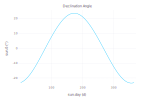

In [57]:
visualize(SunController, "sun.day", "sun.δ";
    title = "Declination Angle",
    config = sun_config,
    xstep = Sun => :day => 1:365,
    kind = :line,
)

In [58]:
manipulate(SunController, "sun.hour", "sun.αs";
    title = "Elevation Angle",
    parameters = Sun => (;
        latitude = -90:0.1:90,
        longitude = -180:0.1:180,
    ),
    config = sun_config,
    xstep = Sun => :hour => 0:23,
    ylim = (-90,90),
    kind = :line,
)

WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any["Sun"], Dict{Symbol, Any}(:style => Dict{String, Any}("color" => :darkorchid, "font-family" => "monospace"))), WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[WebIO.Scope(WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :label), Any["latitude (°)"], Dict{Symbol, Any}(:className => "interact ", :style => Dict{Any, Any}(:padding => "5px 10px 0px 10px", "white-space" => :nowrap, "color" => :royalblue)))], Dict{Symbol, Any}(:className => "interact-flex-row-left")), WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :input), Any[], Dict{Symbol, Any}(:max => 1801, :min => 1, :attributes => Dict{Any, Any}(:type => "range", Symbol("data-bind") => "numericValue: index, valueUpdate: 'input', event: {change: function (){this.changes(this.changes()+1)}}", "orient" => "horizontal"), :step => 1, :className => "slider slider is-fullwidth", :style => Dict{Any, Any}()))], Dict{Symbol, Any}(:className => "interact-flex-row-center")), WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :p), Any[], Dict{Symbol, Any}(:attributes => Dict("data-bind" => "text: formatted_val")))], Dict{Symbol, Any}(:className => "interact-flex-row-right"))], Dict{Symbol, Any}(:className => "interact-flex-row interact-widget", :style => Dict("font-family" => "monospace", "width" => "80%"))), Dict{String, Tuple{Observables.AbstractObservable, Union{Nothing, Bool}}}("changes" => (Observable{Int64} with 2 listeners. Value:
0, nothing), "index" => (Observable{Any} with 2 listeners. Value:
1276, nothing)), Set{String}(), nothing, WebIO.Asset[WebIO.Asset("js", "knockout", "/opt/julia/packages/Knockout/3gjS1/src/../assets/knockout.js"), WebIO.Asset("js", "knockout_punches", "/opt/julia/packages/Knockout/3gjS1/src/../assets/knockout_punches.js"), WebIO.Asset("js", nothing, "/opt/julia/packages/InteractBase/h8Fwe/src/../assets/all.js"), WebIO.Asset("css", nothing, "/opt/julia/packages/InteractBase/h8Fwe/src/../assets/style.css"), WebIO.Asset("css", nothing, "/opt/julia/packages/Interact/pVyN2/src/../assets/bulma_confined.min.css")], Dict{Any, Any}("changes" => Any[WebIO.JSString("(function (val){return (val!=this.model[\"changes\"]()) ? (this.valueFromJulia[\"changes\"]=true, this.model[\"changes\"](val)) : undefined})")], "index" => Any[WebIO.JSString("(function (val){return (val!=this.model[\"index\"]()) ? (this.valueFromJulia[\"index\"]=true, this.model[\"index\"](val)) : undefined})")]), WebIO.ConnectionPool(Channel{Any}(32), Set{WebIO.AbstractConnection}(), Condition(Base.InvasiveLinkedList{Task}(Task (runnable) @0x00007f98b302e400, Task (runnable) @0x00007f98b302e400), Base.AlwaysLockedST(1))), WebIO.JSString[WebIO.JSString("function () {\n    var handler = (function (ko, koPunches) {\n    ko.punches.enableAll();\n    ko.bindingHandlers.numericValue = {\n        init: function(element, valueAccessor, allBindings, data, context) {\n            var stringified = ko.observable(ko.unwrap(valueAccessor()));\n            stringified.subscribe(function(value) {\n                var val = parseFloat(value);\n                if (!isNaN(val)) {\n                    valueAccessor()(val);\n                }\n            });\n            valueAccessor().subscribe(function(value) {\n                var str = JSON.stringify(value);\n                if ((str == \"0\") && ([\"-0\", \"-0.\"].indexOf(stringified()) >= 0))\n                     return;\n                 if ([\"null\", \"\"].indexOf(str) >= 0)\n                     return;\n                stringified(str);\n            });\n            ko.applyBindingsToNode(\n                element,\n                {\n                    value: stringified,\n                    valueUpdate: allBindings.get('valueUpdate'),\n                },\n                context,\n       

In [59]:
manipulate(SunController, "sun.hour", ["sun.Fdir", "sun.Fdif"];
    title = "Directional & Diffusive Coeff.",
    parameters = Sun => (;
        day = 1:365,
        :τ => 0:0.01:1
    ),
    config = sun_config,
    xstep = Sun => :hour => 0:23,
    ylim = (0,1),
    kind = :line,
)

WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any["Sun"], Dict{Symbol, Any}(:style => Dict{String, Any}("color" => :darkorchid, "font-family" => "monospace"))), WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[WebIO.Scope(WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :label), Any["day (d)"], Dict{Symbol, Any}(:className => "interact ", :style => Dict{Any, Any}(:padding => "5px 10px 0px 10px", "white-space" => :nowrap, "color" => :royalblue)))], Dict{Symbol, Any}(:className => "interact-flex-row-left")), WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :input), Any[], Dict{Symbol, Any}(:max => 365, :min => 1, :attributes => Dict{Any, Any}(:type => "range", Symbol("data-bind") => "numericValue: index, valueUpdate: 'input', event: {change: function (){this.changes(this.changes()+1)}}", "orient" => "horizontal"), :step => 1, :className => "slider slider is-fullwidth", :style => Dict{Any, Any}()))], Dict{Symbol, Any}(:className => "interact-flex-row-center")), WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :p), Any[], Dict{Symbol, Any}(:attributes => Dict("data-bind" => "text: formatted_val")))], Dict{Symbol, Any}(:className => "interact-flex-row-right"))], Dict{Symbol, Any}(:className => "interact-flex-row interact-widget", :style => Dict("font-family" => "monospace", "width" => "80%"))), Dict{String, Tuple{Observables.AbstractObservable, Union{Nothing, Bool}}}("changes" => (Observable{Int64} with 2 listeners. Value:
0, nothing), "index" => (Observable{Any} with 2 listeners. Value:
200, nothing)), Set{String}(), nothing, WebIO.Asset[WebIO.Asset("js", "knockout", "/opt/julia/packages/Knockout/3gjS1/src/../assets/knockout.js"), WebIO.Asset("js", "knockout_punches", "/opt/julia/packages/Knockout/3gjS1/src/../assets/knockout_punches.js"), WebIO.Asset("js", nothing, "/opt/julia/packages/InteractBase/h8Fwe/src/../assets/all.js"), WebIO.Asset("css", nothing, "/opt/julia/packages/InteractBase/h8Fwe/src/../assets/style.css"), WebIO.Asset("css", nothing, "/opt/julia/packages/Interact/pVyN2/src/../assets/bulma_confined.min.css")], Dict{Any, Any}("changes" => Any[WebIO.JSString("(function (val){return (val!=this.model[\"changes\"]()) ? (this.valueFromJulia[\"changes\"]=true, this.model[\"changes\"](val)) : undefined})")], "index" => Any[WebIO.JSString("(function (val){return (val!=this.model[\"index\"]()) ? (this.valueFromJulia[\"index\"]=true, this.model[\"index\"](val)) : undefined})")]), WebIO.ConnectionPool(Channel{Any}(32), Set{WebIO.AbstractConnection}(), Condition(Base.InvasiveLinkedList{Task}(Task (runnable) @0x00007f98b3f04180, Task (runnable) @0x00007f98b3f04180), Base.AlwaysLockedST(1))), WebIO.JSString[WebIO.JSString("function () {\n    var handler = (function (ko, koPunches) {\n    ko.punches.enableAll();\n    ko.bindingHandlers.numericValue = {\n        init: function(element, valueAccessor, allBindings, data, context) {\n            var stringified = ko.observable(ko.unwrap(valueAccessor()));\n            stringified.subscribe(function(value) {\n                var val = parseFloat(value);\n                if (!isNaN(val)) {\n                    valueAccessor()(val);\n                }\n            });\n            valueAccessor().subscribe(function(value) {\n                var str = JSON.stringify(value);\n                if ((str == \"0\") && ([\"-0\", \"-0.\"].indexOf(stringified()) >= 0))\n                     return;\n                 if ([\"null\", \"\"].indexOf(str) >= 0)\n                     return;\n                stringified(str);\n            });\n            ko.applyBindingsToNode(\n                element,\n                {\n                    value: stringified,\n                    valueUpdate: allBindings.get('valueUpdate'),\n                },\n                context,\n            );

### 1.3.2. 조도

이제 특정 시점, 장소에서의 직사광(directional light)과 확산광(diffusive light)은 계산할 수 있게 되었습니다. 그렇다면 그곳의 작물 군락(canopy)이 받는 실제 조도는 어떻게 계산할까요? 해당 군락의 형태와 이를 이루는 엽의 분포, 그리고 얼마나 많은 엽이 층층이 쌓여 있는지 등에 따라 개별 엽 단위에서 흡수하는 광량은 크게 달라질 수 있습니다.

군락의 정확한 3차원 구조를 파악하여 개별 엽 단위로 들고 나는 광선을 모두 추적하는(ray casting) 방법이 있을 수도 있습니다. 하지만 구조를 만드는 것부터 광의 추적까지 쉽지 않습니다. 이에 대개의 작물 모형에서는 군락을 크게 두가지 형태로 구분하여 각 부분이 받는 광량을 대표적으로 계산하여 합산하는 방식을 사용합니다. 이때 직사광을 받는 sunlit leaf와 확산광을 받는 shaded leaf로 구분을 하기 때문에 sunlit-shaded leaf 모형이라고 부르기도 합니다.

역시 코드는 복잡해보일 수 있지만 주요 입력 변수는 엽각(leaf angle) 분포와 엽면적지수(leaf area index)라고 보시면 됩니다. 이들에 의해 작물 군락에 다다르는 직사광과 확산광의 비율이 변화하게 되는 것입니다. 최종적으로 결정된 직사광과 확산광의 양을 통해 개별엽 단위 광합성 모형을 두번 구동하고 그 결과를 sunlit과 shaded leaf의 각 부분에 해당하는 엽면적지수 비율만큼 곱하여 합산한 값을 군락 광합성 총량으로 사용합니다.

In [60]:
@enum LeafAngle begin
    spherical = 1
    horizontal = 2
    vertical = 3
    diaheliotropic = 4
    empirical = 5
    ellipsoidal = 6
end

In [61]:
@enum WaveBand begin
    photosynthetically_active_radiation = 1
    near_infrared = 2
    longwave = 3
end

In [62]:
@system Radiation begin
    sun                  ~ ::Sun(override)
    LAI: leaf_area_index ~ track(override)

    leaf_angle => ellipsoidal ~ preserve::LeafAngle(parameter)

    "ratio of horizontal to vertical axis of an ellipsoid"
    LAF: leaf_angle_factor => begin
        #1
        # leaf angle factor for corn leaves, Campbell and Norman (1998)
        #1.37
        # leaf angle factor for garlic canopy, from Rizzalli et al. (2002),  X factor in Campbell and Norman (1998)
        0.7
    end ~ preserve(parameter)

    wave_band => photosynthetically_active_radiation ~ preserve::WaveBand(parameter)

    "scattering coefficient (reflectance + transmittance)"
    s: scattering => 0.15 ~ preserve(parameter)

    "clumping index"
    clumping => 1.0 ~ preserve(parameter)

    # Forward from Sun

    current_zenith_angle(sun.zenith_angle) ~ track(u"°")
    elevation_angle(sun.αs)                ~ track(u"°")

    I0_dr(sun.PARdir): directional_photosynthetic_radiation ~ track(u"μmol/m^2/s" #= Quanta =#)
    I0_df(sun.PARdif): diffusive_photosynthetic_radiation   ~ track(u"μmol/m^2/s" #= Quanta =#)

    leaf_angle_coeff(a=leaf_angle, leaf_angle_factor; zenith_angle(u"°")) => begin
        elevation_angle = 90u"°" - zenith_angle
        α = elevation_angle
        t = zenith_angle
        # leaf angle distribution parameter
        x = leaf_angle_factor
        if a == spherical
            # When Lt accounts for total path length, division by sin(elev) isn't necessary
            1 / (2sin(α))
        elseif a == horizontal
            1
        elseif a == vertical
            1 / (tan(α) * π/2)
        elseif a == empirical
            0.667
        elseif a == diaheliotropic
            1 / sin(α)
        elseif a == ellipsoidal
            sqrt(x^2 + tan(t)^2) / (x + 1.774 * (x+1.182)^-0.733)
        else
            1
        end
    end ~ call

    "extinction coefficient assuming spherical leaf dist"
    Kb_at(leaf_angle_coeff, clumping; zenith_angle(u"°")): projection_ratio_at => begin
        leaf_angle_coeff(zenith_angle) * clumping
    end ~ call

    Kb(Kb_at, current_zenith_angle): projection_ratio => begin
        Kb_at(current_zenith_angle)
    end ~ track

    "diffused light ratio to ambient, integrated over all incident angles from 0 to 90"
    Kd_F(leaf_angle_coeff, LAI; a): diffused_fraction_for_Kd => begin
        c = leaf_angle_coeff(a)
        x = exp(-c * LAI)
        2x * sin(a) * cos(a)
    end ~ integrate(from=0, to=π/2)

    "K for diffuse light, the same literature as above"
    Kd(F=Kd_F, LAI, clumping): diffusion_ratio => begin
        K = -log(F) / LAI
        K * clumping
    end ~ track

    ###############################
    # de Pury and Farquhar (1997) #
    ###############################

    "Kb prime in de Pury and Farquhar(1997)"
    Kb1(Kb, s): projection_ratio_prime => (Kb * sqrt(1 - s)) ~ track

    "Kd prime in de Pury and Farquhar(1997)"
    Kd1(Kd, s): diffusion_ratio_prime => (Kd * sqrt(1 - s)) ~ track

    ################
    # Reflectivity #
    ################

    reflectivity(rho_h, Kb, Kd) => begin
        rho_h * (2Kb / (Kb + Kd))
    end ~ track

    # canopy reflection coefficients for beam horizontal leaves, beam uniform leaves, and diffuse radiations

    """
    canopy reflectance of beam irradiance on horizontal leaves, de Pury and Farquhar (1997)
    also see Campbell and Norman (1998) p 255 for further info on potential problems
    """
    rho_h(s): canopy_reflectivity_horizontal_leaf => begin
        (1 - sqrt(1 - s)) / (1 + sqrt(1 - s))
    end ~ track

    "canopy reflectance of beam irradiance for uniform leaf angle distribution, de Pury and Farquhar (1997)"
    rho_cb_at(rho_h, Kb_at; zenith_angle): canopy_reflectivity_uniform_leaf_at => begin
        Kb = Kb_at(zenith_angle)
        1 - exp(-2rho_h * Kb / (1 + Kb))
    end ~ call

    rho_cb(rho_cb_at, current_zenith_angle): canopy_reflectivity_uniform_leaf => begin
        rho_cb_at(current_zenith_angle)
    end ~ track

    rho_cd_F(rho_cb_at; a): diffused_fraction_for_rho_cd => begin
        x = rho_cb_at(a)
        2x * sin(a) * cos(a)
    end ~ integrate(from=0, to=π/2)

    "canopy reflectance of diffuse irradiance, de Pury and Farquhar (1997) Table A2"
    rho_cd(I0_df, rho_cd_F): canopy_reflectivity_diffusion => begin
        iszero(I0_df) ? 0 : rho_cd_F
    end ~ track

    "soil reflectivity for PAR band"
    rho_soil: soil_reflectivity => 0.10 ~ preserve(parameter)

    #######################
    # I_l?: dePury (1997) #
    #######################

    "dePury (1997) eqn A3"
    I_lb(I0_dr, rho_cb, Kb1; L): irradiance_lb => begin
        I0_dr * (1 - rho_cb) * Kb1 * exp(-Kb1 * L)
    end ~ call(u"μmol/m^2/s" #= Quanta =#)

    "dePury (1997) eqn A5"
    I_ld(I0_df, rho_cb, Kd1; L): irradiance_ld => begin
        I0_df * (1 - rho_cb) * Kd1 * exp(-Kd1 * L)
    end ~ call(u"μmol/m^2/s" #= Quanta =#)

    "dePury (1997) eqn A5"
    I_l(; L): irradiance_l => (I_lb(L) + I_ld(L)) ~ call(u"μmol/m^2/s" #= Quanta =#)

    "dePury (1997) eqn A5"
    I_lbSun(I0_dr, s, Kb, I_lSh; L): irradiance_l_sunlit => begin
        I_lb_sunlit = I0_dr * (1 - s) * Kb
        #TODO: check name I_lbSun vs. I_l_sunlit?
        I_l_sunlit = I_lb_sunlit + I_lSh(L)
    end ~ call(u"μmol/m^2/s" #= Quanta =#)

    "dePury (1997) eqn A5"
    I_lSh(I_ld, I_lbs; L): irradiance_l_shaded => begin
        I_ld(L) + I_lbs(L)
    end ~ call(u"μmol/m^2/s" #= Quanta =#)

    "dePury (1997) eqn A5"
    I_lbs(I0_dr, rho_cb, s, Kb1, Kb; L): irradiance_lbs => begin
        I0_dr * ((1 - rho_cb) * Kb1 * exp(-Kb1 * L) - (1 - s) * Kb * exp(-Kb * L))
    end ~ call(u"μmol/m^2/s" #= Quanta =#)

    """
    total irradiance at the top of the canopy,
    passed over from either observed PAR or TSolar or TIrradiance
    """
    I0_tot(I0_dr, I0_df): irradiance_I0_tot => (I0_dr + I0_df) ~ track(u"μmol/m^2/s" #= Quanta =#)

    ########
    # I_c? #
    ########

    # I_tot, I_sun, I_shade: absorbed irradiance integrated over LAI per ground area

    "Total irradiance absorbed by the canopy, de Pury and Farquhar (1997)"
    I_c(rho_cb, I0_dr, I0_df, Kb1, Kd1, LAI): canopy_irradiance => begin
        #I_c = I_cSun + I_cSh
        I(I0, K) = (1 - rho_cb) * I0 * (1 - exp(-K * LAI))
        I_tot = I(I0_dr, Kb1) + I(I0_df, Kd1)
    end ~ track(u"μmol/m^2/s" #= Quanta =#)

    "The irradiance absorbed by the sunlit fraction, de Pury and Farquhar (1997)"
    I_cSun(s, rho_cb, rho_cd, I0_dr, I0_df, Kb, Kb1, Kd1, LAI): canopy_sunlit_irradiance => begin
        I_c_sunlit = begin
            I0_dr * (1 - s) * (1 - exp(-Kb * LAI)) +
            I0_df * (1 - rho_cd) * (1 - exp(-(Kd1 + Kb) * LAI)) * Kd1 / (Kd1 + Kb) +
            I0_dr * ((1 - rho_cb) * (1 - exp(-(Kb1 + Kb) * LAI)) * Kb1 / (Kb1 + Kb) - (1 - s) * (1 - exp(-2Kb * LAI)) / 2)
        end
    end ~ track(u"μmol/m^2/s" #= Quanta =#)

    "The irradiance absorbed by the shaded fraction, de Pury and Farquhar (1997)"
    I_cSh(I_c, I_cSun): canopy_shaded_irradiance => (I_c - I_cSun) ~ track(u"μmol/m^2/s" #= Quanta =#)

    ######
    # Q? #
    ######

    "total irradiance (dir + dif) at depth L, simple empirical approach"
    Q_tot(I0_tot, s, Kb, Kd; L): irradiance_Q_tot => begin
        I0_tot * exp(-sqrt(1 - s) * ((Kb + Kd) / 2) * L)
    end ~ call(u"μmol/m^2/s" #= Quanta =#)

    "total beam radiation at depth L"
    Q_bt(I0_dr, s, Kb; L): irradiance_Q_bt => begin
        I0_dr * exp(-sqrt(1 - s) * Kb * L)
    end ~ call(u"μmol/m^2/s" #= Quanta =#)

    "net diffuse flux at depth of L within canopy"
    Q_d(I0_dr, s, Kd; L): irradiance_Q_d => begin
        I0_df * exp(-sqrt(1 - s) * Kd * L)
    end ~ call(u"μmol/m^2/s" #= Quanta =#)

    """
    weighted average absorbed diffuse flux over depth of L within canopy
    accounting for exponential decay, Campbell p261
    """
    Q_dm(LAI, I0_df, s, Kd): irradiance_Q_dm => begin
        # Integral Qd / Integral L
        Q = I0_df * (1 - exp(-sqrt(1 - s) * Kd * LAI)) / (sqrt(1 - s) * Kd * LAI)
        isnan(Q) ? zero(Q) : Q
    end ~ track(u"μmol/m^2/s" #= Quanta =#)

    "unintercepted beam (direct beam) flux at depth of L within canopy"
    Q_b(I0_dr, Kb; L): irradiance_Q_b => begin
        I0_dr * exp(-Kb * L)
    end ~ call(u"μmol/m^2/s" #= Quanta =#)

    "mean flux density on sunlit leaves"
    Q_sun(I0_dr, Kb, Q_sh): irradiance_Q_sunlit => begin
        I0_dr * Kb + Q_sh
    end ~ track(u"μmol/m^2/s" #= Quanta =#)

    "flux density on sunlit leaves at depth L"
    Q_sun_at(I0_dr, Kb; L): irradiance_Q_sunlit_at => begin
        I0_dr * Kb + Q_sh_at(L)
    end ~ call(u"μmol/m^2/s" #= Quanta =#)

    "mean flux density on shaded leaves over LAI"
    Q_sh(Q_dm, Q_scm): irradiance_Q_shaded => begin
        # It does not include soil reflection
        Q_dm + Q_scm
    end ~ track(u"μmol/m^2/s" #= Quanta =#)

    "diffuse flux density on shaded leaves at depth L"
    Q_sh_at(Q_d, Q_sc; L): irradiance_Q_shaded_at => begin
        # It does not include soil reflection
        Q_d(L) + Q_sc(L)
    end ~ call(u"μmol/m^2/s" #= Quanta =#)

    "weighted average of Soil reflectance over canopy accounting for exponential decay"
    Q_soilm(LAI, rho_soil, s, Kd, Q_soil): irradiance_Q_soilm => begin
        # Integral Qd / Integral L
        Q = Q_soil * rho_soil * (1 - exp(-sqrt(1 - s) * Kd * LAI)) / (sqrt(1 - s) * Kd * LAI)
        isnan(Q) ? zero(Q) : Q
    end ~ track(u"μmol/m^2/s" #= Quanta =#)

    "weighted average scattered radiation within canopy"
    Q_scm(LAI, I0_dr, s, Kb): irradiance_Q_scm => begin
        # total beam including scattered absorbed by canopy
        #FIXME should the last part be multiplied by LAI like others?
        #TODO simplify by using existing variables (i.e. Q_bt, Q_b)
        total_beam = I0_dr * (1 - exp(-sqrt(1 - s) * Kb * LAI)) / (sqrt(1 - s) * Kb)
        # non scattered beam absorbed by canopy
        nonscattered_beam = I0_dr * (1 - exp(-Kb * LAI)) / Kb
        Q = (total_beam - nonscattered_beam) / LAI
        # Campbell and Norman (1998) p 261, Average between top (where scattering is 0) and bottom.
        #(self.Q_bt(LAI) - Q_b(LAI)) / 2
        isnan(Q) ? zero(Q) : Q
    end ~ track(u"μmol/m^2/s" #= Quanta =#)

    "scattered radiation at depth L in the canopy"
    Q_sc(Q_bt, Q_b; L): irradiance_Q_sc => begin
        # total beam - nonscattered beam at depth L
        Q_bt(L) - Q_b(L)
    end ~ call(u"μmol/m^2/s" #= Quanta =#)

    "total PFD at the soil surface under the canopy"
    Q_soil(LAI, Q_tot): irradiance_Q_soil => Q_tot(LAI) ~ track(u"μmol/m^2/s" #= Quanta =#)

    ###################
    # Leaf Area Index #
    ###################

    sunrisen(elevation_angle, minimum_elevation_angle=5u"°") => begin
        elevation_angle > minimum_elevation_angle
    end ~ flag

    "sunlit LAI assuming closed canopy; thus not accurate for row or isolated canopy"
    LAI_sunlit(sunrisen, Kb, LAI): sunlit_leaf_area_index => begin
        sunrisen ? (1 - exp(-Kb * LAI)) / Kb : 0
    end ~ track

    "shaded LAI assuming closed canopy"
    LAI_shaded(LAI, LAI_sunlit): shaded_leaf_area_index => begin
        LAI - LAI_sunlit
    end ~ track

    "sunlit fraction of current layer"
    sunlit_fraction(sunrisen, Kb; L) => begin
        sunrisen ? exp(-Kb * L) : 0
    end ~ call

    shaded_fraction(sunlit_fraction; L) => begin
        1 - sunlit_fraction(L)
    end ~ call
end

Radiation

In [63]:
@system RadiationController(Radiation, Controller) begin
    weather(context)      ~ ::Weather
    sun(context, weather) ~ ::Sun
    LAI: leaf_area_index  ~ preserve(parameter)
end

RadiationController

In [64]:
manipulate(RadiationController, "sun.hour", [:Q_sun, :Q_sh];
    parameters = (
        Sun => (;
            day = 1:365,
        ),
        :0 => (;
            LAI = 0:20,
        ),
        Radiation => (;
            leaf_angle = [spherical, horizontal, vertical, diaheliotropic, empirical, ellipsoidal],
        ),
    ),
    xstep = Sun => :hour => 0:23,
    ylim = (0,1000),
    kind = :line,
)

WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any["Sun"], Dict{Symbol, Any}(:style => Dict{String, Any}("color" => :darkorchid, "font-family" => "monospace"))), WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[WebIO.Scope(WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :label), Any["day (d)"], Dict{Symbol, Any}(:className => "interact ", :style => Dict{Any, Any}(:padding => "5px 10px 0px 10px", "white-space" => :nowrap, "color" => :royalblue)))], Dict{Symbol, Any}(:className => "interact-flex-row-left")), WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :input), Any[], Dict{Symbol, Any}(:max => 365, :min => 1, :attributes => Dict{Any, Any}(:type => "range", Symbol("data-bind") => "numericValue: index, valueUpdate: 'input', event: {change: function (){this.changes(this.changes()+1)}}", "orient" => "horizontal"), :step => 1, :className => "slider slider is-fullwidth", :style => Dict{Any, Any}()))], Dict{Symbol, Any}(:className => "interact-flex-row-center")), WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :p), Any[], Dict{Symbol, Any}(:attributes => Dict("data-bind" => "text: formatted_val")))], Dict{Symbol, Any}(:className => "interact-flex-row-right"))], Dict{Symbol, Any}(:className => "interact-flex-row interact-widget", :style => Dict("font-family" => "monospace", "width" => "80%"))), Dict{String, Tuple{Observables.AbstractObservable, Union{Nothing, Bool}}}("changes" => (Observable{Int64} with 2 listeners. Value:
0, nothing), "index" => (Observable{Any} with 2 listeners. Value:
183, nothing)), Set{String}(), nothing, WebIO.Asset[WebIO.Asset("js", "knockout", "/opt/julia/packages/Knockout/3gjS1/src/../assets/knockout.js"), WebIO.Asset("js", "knockout_punches", "/opt/julia/packages/Knockout/3gjS1/src/../assets/knockout_punches.js"), WebIO.Asset("js", nothing, "/opt/julia/packages/InteractBase/h8Fwe/src/../assets/all.js"), WebIO.Asset("css", nothing, "/opt/julia/packages/InteractBase/h8Fwe/src/../assets/style.css"), WebIO.Asset("css", nothing, "/opt/julia/packages/Interact/pVyN2/src/../assets/bulma_confined.min.css")], Dict{Any, Any}("changes" => Any[WebIO.JSString("(function (val){return (val!=this.model[\"changes\"]()) ? (this.valueFromJulia[\"changes\"]=true, this.model[\"changes\"](val)) : undefined})")], "index" => Any[WebIO.JSString("(function (val){return (val!=this.model[\"index\"]()) ? (this.valueFromJulia[\"index\"]=true, this.model[\"index\"](val)) : undefined})")]), WebIO.ConnectionPool(Channel{Any}(32), Set{WebIO.AbstractConnection}(), Condition(Base.InvasiveLinkedList{Task}(Task (runnable) @0x00007f98c861e850, Task (runnable) @0x00007f98c861e850), Base.AlwaysLockedST(1))), WebIO.JSString[WebIO.JSString("function () {\n    var handler = (function (ko, koPunches) {\n    ko.punches.enableAll();\n    ko.bindingHandlers.numericValue = {\n        init: function(element, valueAccessor, allBindings, data, context) {\n            var stringified = ko.observable(ko.unwrap(valueAccessor()));\n            stringified.subscribe(function(value) {\n                var val = parseFloat(value);\n                if (!isNaN(val)) {\n                    valueAccessor()(val);\n                }\n            });\n            valueAccessor().subscribe(function(value) {\n                var str = JSON.stringify(value);\n                if ((str == \"0\") && ([\"-0\", \"-0.\"].indexOf(stringified()) >= 0))\n                     return;\n                 if ([\"null\", \"\"].indexOf(str) >= 0)\n                     return;\n                stringified(str);\n            });\n            ko.applyBindingsToNode(\n                element,\n                {\n                    value: stringified,\n                    valueUpdate: allBindings.get('valueUpdate'),\n                },\n                context,\n            );

In [65]:
manipulate(RadiationController, "sun.hour", [:LAI_sunlit, :LAI_shaded];
    config = :0 => :LAI => 10,
    parameters = (
        Sun => (;
            day = 1:365,
        ),
        Radiation => (;
            leaf_angle = [spherical, horizontal, vertical, diaheliotropic, empirical, ellipsoidal],
        ),
    ),
    xstep = Sun => :hour => 0:23,
    kind = :line,
)

WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any["Sun"], Dict{Symbol, Any}(:style => Dict{String, Any}("color" => :darkorchid, "font-family" => "monospace"))), WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[WebIO.Scope(WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :label), Any["day (d)"], Dict{Symbol, Any}(:className => "interact ", :style => Dict{Any, Any}(:padding => "5px 10px 0px 10px", "white-space" => :nowrap, "color" => :royalblue)))], Dict{Symbol, Any}(:className => "interact-flex-row-left")), WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :input), Any[], Dict{Symbol, Any}(:max => 365, :min => 1, :attributes => Dict{Any, Any}(:type => "range", Symbol("data-bind") => "numericValue: index, valueUpdate: 'input', event: {change: function (){this.changes(this.changes()+1)}}", "orient" => "horizontal"), :step => 1, :className => "slider slider is-fullwidth", :style => Dict{Any, Any}()))], Dict{Symbol, Any}(:className => "interact-flex-row-center")), WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :p), Any[], Dict{Symbol, Any}(:attributes => Dict("data-bind" => "text: formatted_val")))], Dict{Symbol, Any}(:className => "interact-flex-row-right"))], Dict{Symbol, Any}(:className => "interact-flex-row interact-widget", :style => Dict("font-family" => "monospace", "width" => "80%"))), Dict{String, Tuple{Observables.AbstractObservable, Union{Nothing, Bool}}}("changes" => (Observable{Int64} with 2 listeners. Value:
0, nothing), "index" => (Observable{Any} with 2 listeners. Value:
183, nothing)), Set{String}(), nothing, WebIO.Asset[WebIO.Asset("js", "knockout", "/opt/julia/packages/Knockout/3gjS1/src/../assets/knockout.js"), WebIO.Asset("js", "knockout_punches", "/opt/julia/packages/Knockout/3gjS1/src/../assets/knockout_punches.js"), WebIO.Asset("js", nothing, "/opt/julia/packages/InteractBase/h8Fwe/src/../assets/all.js"), WebIO.Asset("css", nothing, "/opt/julia/packages/InteractBase/h8Fwe/src/../assets/style.css"), WebIO.Asset("css", nothing, "/opt/julia/packages/Interact/pVyN2/src/../assets/bulma_confined.min.css")], Dict{Any, Any}("changes" => Any[WebIO.JSString("(function (val){return (val!=this.model[\"changes\"]()) ? (this.valueFromJulia[\"changes\"]=true, this.model[\"changes\"](val)) : undefined})")], "index" => Any[WebIO.JSString("(function (val){return (val!=this.model[\"index\"]()) ? (this.valueFromJulia[\"index\"]=true, this.model[\"index\"](val)) : undefined})")]), WebIO.ConnectionPool(Channel{Any}(32), Set{WebIO.AbstractConnection}(), Condition(Base.InvasiveLinkedList{Task}(Task (runnable) @0x00007f98b2f9c5d0, Task (runnable) @0x00007f98b2f9c5d0), Base.AlwaysLockedST(1))), WebIO.JSString[WebIO.JSString("function () {\n    var handler = (function (ko, koPunches) {\n    ko.punches.enableAll();\n    ko.bindingHandlers.numericValue = {\n        init: function(element, valueAccessor, allBindings, data, context) {\n            var stringified = ko.observable(ko.unwrap(valueAccessor()));\n            stringified.subscribe(function(value) {\n                var val = parseFloat(value);\n                if (!isNaN(val)) {\n                    valueAccessor()(val);\n                }\n            });\n            valueAccessor().subscribe(function(value) {\n                var str = JSON.stringify(value);\n                if ((str == \"0\") && ([\"-0\", \"-0.\"].indexOf(stringified()) >= 0))\n                     return;\n                 if ([\"null\", \"\"].indexOf(str) >= 0)\n                     return;\n                stringified(str);\n            });\n            ko.applyBindingsToNode(\n                element,\n                {\n                    value: stringified,\n                    valueUpdate: allBindings.get('valueUpdate'),\n                },\n                context,\n            );

### 1.3.3. 군락 광합성 통합

앞서 언급한 것처럼 sunlit과 shaded leaf에 각각 개별 광합성 모형을 구동하여 합산하는 부분입니다.

`Sun` 시스템에서 계산한 직사광과 확산광을 `Radiation` 시스템에서 군락 형태에 맞춰 조정해주면, 그 값을 이용하여 광합성 모형이 구동됩니다. 각 부위별 엽면적지수 비율만큼 곱해서 합산하여 군락 단위의 총 순광합성률(`A_net`; $\mathrm{\mu mol\; m^{-2}\; s^{-1}}$)을 계산할 수 있습니다. 이를 탄수화물 비율만큼 곱하여 순동화량(`net_assimilation`; $\mathrm{g\; d^{-1}}$)을 구하게 되는 것입니다.

In [66]:
@system C3BB2(GasExchange, StomataBallBerry, C3) begin
    PPFD: photosynthetic_photon_flux_density ~ track(u"μmol/m^2/s" #= Quanta =#, override)
    LAI: leaf_area_index                     ~ track(override)

    A_net_total(A_net, LAI): net_photosynthesis_total       => A_net * LAI   ~ track(u"μmol/m^2/s" #= CO2 =#)
    A_gross_total(A_gross, LAI): gross_photosynthesis_total => A_gross * LAI ~ track(u"μmol/m^2/s" #= CO2 =#)
    E_total(E, LAI): transpiration_total                    => E * LAI       ~ track(u"mmol/m^2/s" #= H2O =#)
end

C3BB2

In [67]:
@system Photosynthesis(Controller) begin
    weather(context)             ~ ::Weather
    sun(context, weather)        ~ ::Sun
    radiation(context, sun, LAI) ~ ::Radiation

    LAI: leaf_area_index       ~ preserve(parameter)
    PD: planting_density => 55 ~ preserve(parameter, u"m^-2")

    H2O_weight  => 18.01528 ~ preserve(u"g/mol")
    CO2_weight  => 44.0098  ~ preserve(u"g/mol")
    CH2O_weight => 30.031   ~ preserve(u"g/mol")

    sunlit_gasexchange(context, weather, PPFD=Q_sun, LAI=LAI_sunlit) ~ ::C3BB2
    shaded_gasexchange(context, weather, PPFD=Q_sh,  LAI=LAI_shaded) ~ ::C3BB2

    leaf_width => begin
        #5.0 # for maize
        1.5 # for garlic
    end ~ preserve(u"cm", parameter)

    LAI_sunlit(radiation.sunlit_leaf_area_index): sunlit_leaf_area_index ~ track
    LAI_shaded(radiation.shaded_leaf_area_index): shaded_leaf_area_index ~ track

    Q_sun(radiation.irradiance_Q_sunlit): sunlit_irradiance ~ track(u"μmol/m^2/s" #= Quanta =#)
    Q_sh(radiation.irradiance_Q_shaded): shaded_irradiance  ~ track(u"μmol/m^2/s" #= Quanta =#)

    A_gross(a=sunlit_gasexchange.A_gross_total, b=shaded_gasexchange.A_gross_total): gross_CO2_umol_per_m2_s => begin
        a + b
    end ~ track(u"μmol/m^2/s" #= CO2 =#)

    A_net(a=sunlit_gasexchange.A_net_total, b=shaded_gasexchange.A_net_total): net_CO2_umol_per_m2_s => begin
        a + b
    end ~ track(u"μmol/m^2/s" #= CO2 =#)

    gross_assimilation(A_gross, PD, w=CH2O_weight) => begin
        A_gross / PD * w
    end ~ track(u"g/d")

    net_assimilation(A_net, PD, w=CH2O_weight) => begin
        A_net / PD * w
    end ~ track(u"g/d")

    conductance(gs_sun=sunlit_gasexchange.gs, LAI_sunlit, gs_sh=shaded_gasexchange.gs, LAI_shaded, LAI) => begin
        c = ((gs_sun * LAI_sunlit) + (gs_sh * LAI_shaded)) / LAI
        iszero(LAI) ? zero(c) : c
    end ~ track(u"mol/m^2/s/bar")
end

Photosynthesis

In [68]:
config = @config(
    Sun => (;
        day = 200,
        hour = 12,
    ),
    StomataBallBerry => (;
        g0 = 0.096,
        g1 = 6.824,
    ),
    Photosynthesis => (;
        :LAI => 5,
    ),
    Radiation => (;
        :leaf_angle_factor => 3,
        :leaf_angle => horizontal,
    ),
)

Config for 4 systems:
  Sun
    day  = 200 d
    hour = 12 hr
  StomataBallBerry
    g0 = 0.096 mol bar^-1 m^-2 s^-1
    g1 = 6.824
  Photosynthesis
    LAI = 5
  Radiation
    leaf_angle_factor = 3
    leaf_angle        = horizontal

In [69]:
manipulate(Photosynthesis, "weather.CO2", [:A_net, "sunlit_gasexchange.A_net", "shaded_gasexchange.A_net"];
    config,
    parameters = (
        Photosynthesis => :LAI => 0:0.1:20,
        Radiation => (;
            leaf_angle = [spherical, horizontal, vertical, diaheliotropic, empirical, ellipsoidal],
        ),
    ),
    xstep = Weather => :CO2 => 10:10:1000,
    ylim = (0,50),
    kind = :line,
)

WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any["Photosynthesis"], Dict{Symbol, Any}(:style => Dict{String, Any}("color" => :darkorchid, "font-family" => "monospace"))), WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[WebIO.Scope(WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :label), Any["LAI"], Dict{Symbol, Any}(:className => "interact ", :style => Dict{Any, Any}(:padding => "5px 10px 0px 10px", "white-space" => :nowrap, "color" => :royalblue)))], Dict{Symbol, Any}(:className => "interact-flex-row-left")), WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :input), Any[], Dict{Symbol, Any}(:max => 201, :min => 1, :attributes => Dict{Any, Any}(:type => "range", Symbol("data-bind") => "numericValue: index, valueUpdate: 'input', event: {change: function (){this.changes(this.changes()+1)}}", "orient" => "horizontal"), :step => 1, :className => "slider slider is-fullwidth", :style => Dict{Any, Any}()))], Dict{Symbol, Any}(:className => "interact-flex-row-center")), WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :p), Any[], Dict{Symbol, Any}(:attributes => Dict("data-bind" => "text: formatted_val")))], Dict{Symbol, Any}(:className => "interact-flex-row-right"))], Dict{Symbol, Any}(:className => "interact-flex-row interact-widget", :style => Dict("font-family" => "monospace", "width" => "80%"))), Dict{String, Tuple{Observables.AbstractObservable, Union{Nothing, Bool}}}("changes" => (Observable{Int64} with 2 listeners. Value:
0, nothing), "index" => (Observable{Any} with 2 listeners. Value:
51, nothing)), Set{String}(), nothing, WebIO.Asset[WebIO.Asset("js", "knockout", "/opt/julia/packages/Knockout/3gjS1/src/../assets/knockout.js"), WebIO.Asset("js", "knockout_punches", "/opt/julia/packages/Knockout/3gjS1/src/../assets/knockout_punches.js"), WebIO.Asset("js", nothing, "/opt/julia/packages/InteractBase/h8Fwe/src/../assets/all.js"), WebIO.Asset("css", nothing, "/opt/julia/packages/InteractBase/h8Fwe/src/../assets/style.css"), WebIO.Asset("css", nothing, "/opt/julia/packages/Interact/pVyN2/src/../assets/bulma_confined.min.css")], Dict{Any, Any}("changes" => Any[WebIO.JSString("(function (val){return (val!=this.model[\"changes\"]()) ? (this.valueFromJulia[\"changes\"]=true, this.model[\"changes\"](val)) : undefined})")], "index" => Any[WebIO.JSString("(function (val){return (val!=this.model[\"index\"]()) ? (this.valueFromJulia[\"index\"]=true, this.model[\"index\"](val)) : undefined})")]), WebIO.ConnectionPool(Channel{Any}(32), Set{WebIO.AbstractConnection}(), Condition(Base.InvasiveLinkedList{Task}(Task (runnable) @0x00007f98b6b226e0, Task (runnable) @0x00007f98b6b226e0), Base.AlwaysLockedST(1))), WebIO.JSString[WebIO.JSString("function () {\n    var handler = (function (ko, koPunches) {\n    ko.punches.enableAll();\n    ko.bindingHandlers.numericValue = {\n        init: function(element, valueAccessor, allBindings, data, context) {\n            var stringified = ko.observable(ko.unwrap(valueAccessor()));\n            stringified.subscribe(function(value) {\n                var val = parseFloat(value);\n                if (!isNaN(val)) {\n                    valueAccessor()(val);\n                }\n            });\n            valueAccessor().subscribe(function(value) {\n                var str = JSON.stringify(value);\n                if ((str == \"0\") && ([\"-0\", \"-0.\"].indexOf(stringified()) >= 0))\n                     return;\n                 if ([\"null\", \"\"].indexOf(str) >= 0)\n                     return;\n                stringified(str);\n            });\n            ko.applyBindingsToNode(\n                element,\n                {\n                    value: stringified,\n                    valueUpdate: allBindings.get('valueUpdate'),\n                },\n                context,\n        

In [70]:
manipulate(Photosynthesis, "weather.PFD", [:A_net, "sunlit_gasexchange.A_net", "shaded_gasexchange.A_net"];
    config,
    parameters = (
        Photosynthesis => :LAI => 0:0.1:20,
        Radiation => (;
            leaf_angle = [spherical, horizontal, vertical, diaheliotropic, empirical, ellipsoidal],
        ),
    ),
    xstep = Weather => :PFD => 0:10:2000,
    ylim = (0,50),
    kind = :line,
)

WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any["Photosynthesis"], Dict{Symbol, Any}(:style => Dict{String, Any}("color" => :darkorchid, "font-family" => "monospace"))), WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[WebIO.Scope(WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :label), Any["LAI"], Dict{Symbol, Any}(:className => "interact ", :style => Dict{Any, Any}(:padding => "5px 10px 0px 10px", "white-space" => :nowrap, "color" => :royalblue)))], Dict{Symbol, Any}(:className => "interact-flex-row-left")), WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :input), Any[], Dict{Symbol, Any}(:max => 201, :min => 1, :attributes => Dict{Any, Any}(:type => "range", Symbol("data-bind") => "numericValue: index, valueUpdate: 'input', event: {change: function (){this.changes(this.changes()+1)}}", "orient" => "horizontal"), :step => 1, :className => "slider slider is-fullwidth", :style => Dict{Any, Any}()))], Dict{Symbol, Any}(:className => "interact-flex-row-center")), WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :p), Any[], Dict{Symbol, Any}(:attributes => Dict("data-bind" => "text: formatted_val")))], Dict{Symbol, Any}(:className => "interact-flex-row-right"))], Dict{Symbol, Any}(:className => "interact-flex-row interact-widget", :style => Dict("font-family" => "monospace", "width" => "80%"))), Dict{String, Tuple{Observables.AbstractObservable, Union{Nothing, Bool}}}("changes" => (Observable{Int64} with 2 listeners. Value:
0, nothing), "index" => (Observable{Any} with 2 listeners. Value:
51, nothing)), Set{String}(), nothing, WebIO.Asset[WebIO.Asset("js", "knockout", "/opt/julia/packages/Knockout/3gjS1/src/../assets/knockout.js"), WebIO.Asset("js", "knockout_punches", "/opt/julia/packages/Knockout/3gjS1/src/../assets/knockout_punches.js"), WebIO.Asset("js", nothing, "/opt/julia/packages/InteractBase/h8Fwe/src/../assets/all.js"), WebIO.Asset("css", nothing, "/opt/julia/packages/InteractBase/h8Fwe/src/../assets/style.css"), WebIO.Asset("css", nothing, "/opt/julia/packages/Interact/pVyN2/src/../assets/bulma_confined.min.css")], Dict{Any, Any}("changes" => Any[WebIO.JSString("(function (val){return (val!=this.model[\"changes\"]()) ? (this.valueFromJulia[\"changes\"]=true, this.model[\"changes\"](val)) : undefined})")], "index" => Any[WebIO.JSString("(function (val){return (val!=this.model[\"index\"]()) ? (this.valueFromJulia[\"index\"]=true, this.model[\"index\"](val)) : undefined})")]), WebIO.ConnectionPool(Channel{Any}(32), Set{WebIO.AbstractConnection}(), Condition(Base.InvasiveLinkedList{Task}(Task (runnable) @0x00007f98b297af80, Task (runnable) @0x00007f98b297af80), Base.AlwaysLockedST(1))), WebIO.JSString[WebIO.JSString("function () {\n    var handler = (function (ko, koPunches) {\n    ko.punches.enableAll();\n    ko.bindingHandlers.numericValue = {\n        init: function(element, valueAccessor, allBindings, data, context) {\n            var stringified = ko.observable(ko.unwrap(valueAccessor()));\n            stringified.subscribe(function(value) {\n                var val = parseFloat(value);\n                if (!isNaN(val)) {\n                    valueAccessor()(val);\n                }\n            });\n            valueAccessor().subscribe(function(value) {\n                var str = JSON.stringify(value);\n                if ((str == \"0\") && ([\"-0\", \"-0.\"].indexOf(stringified()) >= 0))\n                     return;\n                 if ([\"null\", \"\"].indexOf(str) >= 0)\n                     return;\n                stringified(str);\n            });\n            ko.applyBindingsToNode(\n                element,\n                {\n                    value: stringified,\n                    valueUpdate: allBindings.get('valueUpdate'),\n                },\n                context,\n        

In [71]:
manipulate(Photosynthesis, "weather.T_air", [:A_net, "sunlit_gasexchange.A_net", "shaded_gasexchange.A_net"];
    config,
    parameters = (
        Photosynthesis => :LAI => 0:0.1:20,
        Radiation => (;
            leaf_angle = [spherical, horizontal, vertical, diaheliotropic, empirical, ellipsoidal],
        ),
    ),
    xstep = Weather => :T_air => -10:50,
    ylim = (0,50),
    kind = :line,
)

WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any["Photosynthesis"], Dict{Symbol, Any}(:style => Dict{String, Any}("color" => :darkorchid, "font-family" => "monospace"))), WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[WebIO.Scope(WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :label), Any["LAI"], Dict{Symbol, Any}(:className => "interact ", :style => Dict{Any, Any}(:padding => "5px 10px 0px 10px", "white-space" => :nowrap, "color" => :royalblue)))], Dict{Symbol, Any}(:className => "interact-flex-row-left")), WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :input), Any[], Dict{Symbol, Any}(:max => 201, :min => 1, :attributes => Dict{Any, Any}(:type => "range", Symbol("data-bind") => "numericValue: index, valueUpdate: 'input', event: {change: function (){this.changes(this.changes()+1)}}", "orient" => "horizontal"), :step => 1, :className => "slider slider is-fullwidth", :style => Dict{Any, Any}()))], Dict{Symbol, Any}(:className => "interact-flex-row-center")), WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :p), Any[], Dict{Symbol, Any}(:attributes => Dict("data-bind" => "text: formatted_val")))], Dict{Symbol, Any}(:className => "interact-flex-row-right"))], Dict{Symbol, Any}(:className => "interact-flex-row interact-widget", :style => Dict("font-family" => "monospace", "width" => "80%"))), Dict{String, Tuple{Observables.AbstractObservable, Union{Nothing, Bool}}}("changes" => (Observable{Int64} with 2 listeners. Value:
0, nothing), "index" => (Observable{Any} with 2 listeners. Value:
51, nothing)), Set{String}(), nothing, WebIO.Asset[WebIO.Asset("js", "knockout", "/opt/julia/packages/Knockout/3gjS1/src/../assets/knockout.js"), WebIO.Asset("js", "knockout_punches", "/opt/julia/packages/Knockout/3gjS1/src/../assets/knockout_punches.js"), WebIO.Asset("js", nothing, "/opt/julia/packages/InteractBase/h8Fwe/src/../assets/all.js"), WebIO.Asset("css", nothing, "/opt/julia/packages/InteractBase/h8Fwe/src/../assets/style.css"), WebIO.Asset("css", nothing, "/opt/julia/packages/Interact/pVyN2/src/../assets/bulma_confined.min.css")], Dict{Any, Any}("changes" => Any[WebIO.JSString("(function (val){return (val!=this.model[\"changes\"]()) ? (this.valueFromJulia[\"changes\"]=true, this.model[\"changes\"](val)) : undefined})")], "index" => Any[WebIO.JSString("(function (val){return (val!=this.model[\"index\"]()) ? (this.valueFromJulia[\"index\"]=true, this.model[\"index\"](val)) : undefined})")]), WebIO.ConnectionPool(Channel{Any}(32), Set{WebIO.AbstractConnection}(), Condition(Base.InvasiveLinkedList{Task}(Task (runnable) @0x00007f98b2fc3260, Task (runnable) @0x00007f98b2fc3260), Base.AlwaysLockedST(1))), WebIO.JSString[WebIO.JSString("function () {\n    var handler = (function (ko, koPunches) {\n    ko.punches.enableAll();\n    ko.bindingHandlers.numericValue = {\n        init: function(element, valueAccessor, allBindings, data, context) {\n            var stringified = ko.observable(ko.unwrap(valueAccessor()));\n            stringified.subscribe(function(value) {\n                var val = parseFloat(value);\n                if (!isNaN(val)) {\n                    valueAccessor()(val);\n                }\n            });\n            valueAccessor().subscribe(function(value) {\n                var str = JSON.stringify(value);\n                if ((str == \"0\") && ([\"-0\", \"-0.\"].indexOf(stringified()) >= 0))\n                     return;\n                 if ([\"null\", \"\"].indexOf(str) >= 0)\n                     return;\n                stringified(str);\n            });\n            ko.applyBindingsToNode(\n                element,\n                {\n                    value: stringified,\n                    valueUpdate: allBindings.get('valueUpdate'),\n                },\n                context,\n        

## 1.4. 모형 응용

오전에 PGES 프로그램을 사용하였던 것과 유사하게 이곳 노트북에서 Cropbox를 활용하여 여러가지 응용을 실험해볼 수 있습니다. 강의자료 후반부에 extra로 남겨져 있던 문제들을 살펴보겠습니다.

### Ex. 1.6.
Test the hypothesis that a greater leaf area in a crop canopy will result in greater productivity of the crop. Discuss the modeling outcome and whether you accept or reject the hypothesis and why.

In [72]:
manipulate(Photosynthesis, :LAI, :A_net;
    config = (config, Radiation => :leaf_angle => vertical),
    parameters = (
        Radiation => (;
            :leaf_angle => [spherical, horizontal, vertical, diaheliotropic, empirical, ellipsoidal],
        ),
    ),
    xstep = Photosynthesis => :LAI => 0:20,
    ylim = (0,100),
    kind = :line,
)

WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any["Radiation"], Dict{Symbol, Any}(:style => Dict{String, Any}("color" => :darkorchid, "font-family" => "monospace"))), WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[WebIO.Scope(WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any["leaf_angle", WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :select), Any[], Dict{Symbol, Any}(:attributes => Dict{Union{String, Symbol}, Any}(Symbol("data-bind") => "options : options_js, value : index, optionsText: 'key', optionsValue: 'val', valueAllowUnset: true, optionsAfterRender: disablePlaceholder")))], Dict{Symbol, Any}(:className => "select ", :style => Dict("margin" => "-13px 0 0 20px")))], Dict{Symbol, Any}(:style => Dict{String, Any}("padding" => "5px 10px 20px", "color" => :royalblue, "font-family" => "monospace"))), Dict{String, Tuple{Observables.AbstractObservable, Union{Nothing, Bool}}}("options_js" => (Observable{Vector{OrderedCollections.OrderedDict}} with 1 listeners. Value:
OrderedCollections.OrderedDict[OrderedCollections.OrderedDict{String, Any}("key" => "spherical", "val" => 1, "id" => "idqdhsUpAN"), OrderedCollections.OrderedDict{String, Any}("key" => "horizontal", "val" => 2, "id" => "id5jzQbJn5"), OrderedCollections.OrderedDict{String, Any}("key" => "vertical", "val" => 3, "id" => "idBu1DpM5v"), OrderedCollections.OrderedDict{String, Any}("key" => "diaheliotropic", "val" => 4, "id" => "idzUmqcAnh"), OrderedCollections.OrderedDict{String, Any}("key" => "empirical", "val" => 5, "id" => "ids41RmgfH"), OrderedCollections.OrderedDict{String, Any}("key" => "ellipsoidal", "val" => 6, "id" => "idvCEGEfc5")], nothing), "index" => (Observable{Any} with 3 listeners. Value:
3, nothing)), Set{String}(), nothing, WebIO.Asset[WebIO.Asset("js", "knockout", "/opt/julia/packages/Knockout/3gjS1/src/../assets/knockout.js"), WebIO.Asset("js", "knockout_punches", "/opt/julia/packages/Knockout/3gjS1/src/../assets/knockout_punches.js"), WebIO.Asset("js", nothing, "/opt/julia/packages/InteractBase/h8Fwe/src/../assets/all.js"), WebIO.Asset("css", nothing, "/opt/julia/packages/InteractBase/h8Fwe/src/../assets/style.css"), WebIO.Asset("css", nothing, "/opt/julia/packages/Interact/pVyN2/src/../assets/bulma_confined.min.css")], Dict{Any, Any}("options_js" => Any[WebIO.JSString("(function (val){return (val!=this.model[\"options_js\"]()) ? (this.valueFromJulia[\"options_js\"]=true, this.model[\"options_js\"](val)) : undefined})")], "index" => Any[WebIO.JSString("(function (val){return (val!=this.model[\"index\"]()) ? (this.valueFromJulia[\"index\"]=true, this.model[\"index\"](val)) : undefined})")]), WebIO.ConnectionPool(Channel{Any}(32), Set{WebIO.AbstractConnection}(), Condition(Base.InvasiveLinkedList{Task}(Task (runnable) @0x00007f98b2978460, Task (runnable) @0x00007f98b2978460), Base.AlwaysLockedST(1))), WebIO.JSString[WebIO.JSString("function () {\n    var handler = (function (ko, koPunches) {\n    ko.punches.enableAll();\n    ko.bindingHandlers.numericValue = {\n        init: function(element, valueAccessor, allBindings, data, context) {\n            var stringified = ko.observable(ko.unwrap(valueAccessor()));\n            stringified.subscribe(function(value) {\n                var val = parseFloat(value);\n                if (!isNaN(val)) {\n                    valueAccessor()(val);\n                }\n            });\n            valueAccessor().subscribe(function(value) {\n                var str = JSON.stringify(value);\n                if ((str == \"0\") && ([\"-0\", \"-0.\"].indexOf(stringified()) >= 0))\n                     return;\n                 if ([\"null\", \"\"].indexOf(str) >= 0)\n                     return;\n                stringified(str);\n            });\n            ko.applyBindingsToNode(\n                element,\n                {\n                    value: stringified,\n                    valueUpdate: allBindings.get('valueUpdate

### Ex 1.7.
Test the hypothesis if a crop canopy will be more productive to fix CO2 on a cloudy day or sunny day if the light intensity is the same. Test it with model and explain why.

In [73]:
manipulate(Photosynthesis, "weather.CO2", :A_net;
    config,
    parameters = (
        Sun => (;
            :τ => 0:0.01:1,
        ),
        Photosynthesis => (;
            :LAI => 0:0.1:20,
        ),
    ),
    xstep = Weather => :CO2 => 10:10:800,
    ylim = (0,50),
    kind = :line,
)

WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any["Sun"], Dict{Symbol, Any}(:style => Dict{String, Any}("color" => :darkorchid, "font-family" => "monospace"))), WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[WebIO.Scope(WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :label), Any["τ"], Dict{Symbol, Any}(:className => "interact ", :style => Dict{Any, Any}(:padding => "5px 10px 0px 10px", "white-space" => :nowrap, "color" => :royalblue)))], Dict{Symbol, Any}(:className => "interact-flex-row-left")), WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :input), Any[], Dict{Symbol, Any}(:max => 101, :min => 1, :attributes => Dict{Any, Any}(:type => "range", Symbol("data-bind") => "numericValue: index, valueUpdate: 'input', event: {change: function (){this.changes(this.changes()+1)}}", "orient" => "horizontal"), :step => 1, :className => "slider slider is-fullwidth", :style => Dict{Any, Any}()))], Dict{Symbol, Any}(:className => "interact-flex-row-center")), WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :p), Any[], Dict{Symbol, Any}(:attributes => Dict("data-bind" => "text: formatted_val")))], Dict{Symbol, Any}(:className => "interact-flex-row-right"))], Dict{Symbol, Any}(:className => "interact-flex-row interact-widget", :style => Dict("font-family" => "monospace", "width" => "80%"))), Dict{String, Tuple{Observables.AbstractObservable, Union{Nothing, Bool}}}("changes" => (Observable{Int64} with 2 listeners. Value:
0, nothing), "index" => (Observable{Any} with 2 listeners. Value:
51, nothing)), Set{String}(), nothing, WebIO.Asset[WebIO.Asset("js", "knockout", "/opt/julia/packages/Knockout/3gjS1/src/../assets/knockout.js"), WebIO.Asset("js", "knockout_punches", "/opt/julia/packages/Knockout/3gjS1/src/../assets/knockout_punches.js"), WebIO.Asset("js", nothing, "/opt/julia/packages/InteractBase/h8Fwe/src/../assets/all.js"), WebIO.Asset("css", nothing, "/opt/julia/packages/InteractBase/h8Fwe/src/../assets/style.css"), WebIO.Asset("css", nothing, "/opt/julia/packages/Interact/pVyN2/src/../assets/bulma_confined.min.css")], Dict{Any, Any}("changes" => Any[WebIO.JSString("(function (val){return (val!=this.model[\"changes\"]()) ? (this.valueFromJulia[\"changes\"]=true, this.model[\"changes\"](val)) : undefined})")], "index" => Any[WebIO.JSString("(function (val){return (val!=this.model[\"index\"]()) ? (this.valueFromJulia[\"index\"]=true, this.model[\"index\"](val)) : undefined})")]), WebIO.ConnectionPool(Channel{Any}(32), Set{WebIO.AbstractConnection}(), Condition(Base.InvasiveLinkedList{Task}(Task (runnable) @0x00007f98b2f9e570, Task (runnable) @0x00007f98b2f9e570), Base.AlwaysLockedST(1))), WebIO.JSString[WebIO.JSString("function () {\n    var handler = (function (ko, koPunches) {\n    ko.punches.enableAll();\n    ko.bindingHandlers.numericValue = {\n        init: function(element, valueAccessor, allBindings, data, context) {\n            var stringified = ko.observable(ko.unwrap(valueAccessor()));\n            stringified.subscribe(function(value) {\n                var val = parseFloat(value);\n                if (!isNaN(val)) {\n                    valueAccessor()(val);\n                }\n            });\n            valueAccessor().subscribe(function(value) {\n                var str = JSON.stringify(value);\n                if ((str == \"0\") && ([\"-0\", \"-0.\"].indexOf(stringified()) >= 0))\n                     return;\n                 if ([\"null\", \"\"].indexOf(str) >= 0)\n                     return;\n                stringified(str);\n            });\n            ko.applyBindingsToNode(\n                element,\n                {\n                    value: stringified,\n                    valueUpdate: allBindings.get('valueUpdate'),\n                },\n                context,\n            );\n     

In [74]:
manipulate(Photosynthesis, "weather.CO2", :A_net;
    config,
    parameters = (
        Photosynthesis => (;
            :LAI => 0:0.1:20,
        ),
        Weather => (;
            :PFD => 0:10:2000,
        ),
        Sun => (;
            :day => 1:365,
        ),
    ),
    xstep = Weather => :CO2 => 10:10:800,
    group = Sun => :τ => [0.3, 0.7],
    ylim = (0,50),
    kind = :line,
)

WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any["Photosynthesis"], Dict{Symbol, Any}(:style => Dict{String, Any}("color" => :darkorchid, "font-family" => "monospace"))), WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[WebIO.Scope(WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :label), Any["LAI"], Dict{Symbol, Any}(:className => "interact ", :style => Dict{Any, Any}(:padding => "5px 10px 0px 10px", "white-space" => :nowrap, "color" => :royalblue)))], Dict{Symbol, Any}(:className => "interact-flex-row-left")), WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :input), Any[], Dict{Symbol, Any}(:max => 201, :min => 1, :attributes => Dict{Any, Any}(:type => "range", Symbol("data-bind") => "numericValue: index, valueUpdate: 'input', event: {change: function (){this.changes(this.changes()+1)}}", "orient" => "horizontal"), :step => 1, :className => "slider slider is-fullwidth", :style => Dict{Any, Any}()))], Dict{Symbol, Any}(:className => "interact-flex-row-center")), WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :p), Any[], Dict{Symbol, Any}(:attributes => Dict("data-bind" => "text: formatted_val")))], Dict{Symbol, Any}(:className => "interact-flex-row-right"))], Dict{Symbol, Any}(:className => "interact-flex-row interact-widget", :style => Dict("font-family" => "monospace", "width" => "80%"))), Dict{String, Tuple{Observables.AbstractObservable, Union{Nothing, Bool}}}("changes" => (Observable{Int64} with 2 listeners. Value:
0, nothing), "index" => (Observable{Any} with 2 listeners. Value:
51, nothing)), Set{String}(), nothing, WebIO.Asset[WebIO.Asset("js", "knockout", "/opt/julia/packages/Knockout/3gjS1/src/../assets/knockout.js"), WebIO.Asset("js", "knockout_punches", "/opt/julia/packages/Knockout/3gjS1/src/../assets/knockout_punches.js"), WebIO.Asset("js", nothing, "/opt/julia/packages/InteractBase/h8Fwe/src/../assets/all.js"), WebIO.Asset("css", nothing, "/opt/julia/packages/InteractBase/h8Fwe/src/../assets/style.css"), WebIO.Asset("css", nothing, "/opt/julia/packages/Interact/pVyN2/src/../assets/bulma_confined.min.css")], Dict{Any, Any}("changes" => Any[WebIO.JSString("(function (val){return (val!=this.model[\"changes\"]()) ? (this.valueFromJulia[\"changes\"]=true, this.model[\"changes\"](val)) : undefined})")], "index" => Any[WebIO.JSString("(function (val){return (val!=this.model[\"index\"]()) ? (this.valueFromJulia[\"index\"]=true, this.model[\"index\"](val)) : undefined})")]), WebIO.ConnectionPool(Channel{Any}(32), Set{WebIO.AbstractConnection}(), Condition(Base.InvasiveLinkedList{Task}(Task (runnable) @0x00007f98b2fc05d0, Task (runnable) @0x00007f98b2fc05d0), Base.AlwaysLockedST(1))), WebIO.JSString[WebIO.JSString("function () {\n    var handler = (function (ko, koPunches) {\n    ko.punches.enableAll();\n    ko.bindingHandlers.numericValue = {\n        init: function(element, valueAccessor, allBindings, data, context) {\n            var stringified = ko.observable(ko.unwrap(valueAccessor()));\n            stringified.subscribe(function(value) {\n                var val = parseFloat(value);\n                if (!isNaN(val)) {\n                    valueAccessor()(val);\n                }\n            });\n            valueAccessor().subscribe(function(value) {\n                var str = JSON.stringify(value);\n                if ((str == \"0\") && ([\"-0\", \"-0.\"].indexOf(stringified()) >= 0))\n                     return;\n                 if ([\"null\", \"\"].indexOf(str) >= 0)\n                     return;\n                stringified(str);\n            });\n            ko.applyBindingsToNode(\n                element,\n                {\n                    value: stringified,\n                    valueUpdate: allBindings.get('valueUpdate'),\n                },\n                context,\n        

### Ex 1.8.
Discuss and test if improving leaf photosynthetic capacity by engineering Rubisco in C3 plants will be an effective adaptive breeding strategy for the future climate with rising temperature and $\mathrm{CO_2}$.

In [75]:
manipulate(Photosynthesis, "weather.CO2", :A_net;
    config,
    parameters = (
        C3 => (;
            Vcm25 = 10:200,
        ),
        Photosynthesis => (;
            LAI = 0:0.1:20,
        ),
    ),
    xstep = Weather => :CO2 => 10:10:1000,
    ylim = (0,50),
    kind = :line,
)

WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any["C3"], Dict{Symbol, Any}(:style => Dict{String, Any}("color" => :darkorchid, "font-family" => "monospace"))), WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[WebIO.Scope(WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :label), Any["Vcm25 (μmol m^-2 s^-1)"], Dict{Symbol, Any}(:className => "interact ", :style => Dict{Any, Any}(:padding => "5px 10px 0px 10px", "white-space" => :nowrap, "color" => :royalblue)))], Dict{Symbol, Any}(:className => "interact-flex-row-left")), WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :input), Any[], Dict{Symbol, Any}(:max => 191, :min => 1, :attributes => Dict{Any, Any}(:type => "range", Symbol("data-bind") => "numericValue: index, valueUpdate: 'input', event: {change: function (){this.changes(this.changes()+1)}}", "orient" => "horizontal"), :step => 1, :className => "slider slider is-fullwidth", :style => Dict{Any, Any}()))], Dict{Symbol, Any}(:className => "interact-flex-row-center")), WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :p), Any[], Dict{Symbol, Any}(:attributes => Dict("data-bind" => "text: formatted_val")))], Dict{Symbol, Any}(:className => "interact-flex-row-right"))], Dict{Symbol, Any}(:className => "interact-flex-row interact-widget", :style => Dict("font-family" => "monospace", "width" => "80%"))), Dict{String, Tuple{Observables.AbstractObservable, Union{Nothing, Bool}}}("changes" => (Observable{Int64} with 2 listeners. Value:
0, nothing), "index" => (Observable{Any} with 2 listeners. Value:
96, nothing)), Set{String}(), nothing, WebIO.Asset[WebIO.Asset("js", "knockout", "/opt/julia/packages/Knockout/3gjS1/src/../assets/knockout.js"), WebIO.Asset("js", "knockout_punches", "/opt/julia/packages/Knockout/3gjS1/src/../assets/knockout_punches.js"), WebIO.Asset("js", nothing, "/opt/julia/packages/InteractBase/h8Fwe/src/../assets/all.js"), WebIO.Asset("css", nothing, "/opt/julia/packages/InteractBase/h8Fwe/src/../assets/style.css"), WebIO.Asset("css", nothing, "/opt/julia/packages/Interact/pVyN2/src/../assets/bulma_confined.min.css")], Dict{Any, Any}("changes" => Any[WebIO.JSString("(function (val){return (val!=this.model[\"changes\"]()) ? (this.valueFromJulia[\"changes\"]=true, this.model[\"changes\"](val)) : undefined})")], "index" => Any[WebIO.JSString("(function (val){return (val!=this.model[\"index\"]()) ? (this.valueFromJulia[\"index\"]=true, this.model[\"index\"](val)) : undefined})")]), WebIO.ConnectionPool(Channel{Any}(32), Set{WebIO.AbstractConnection}(), Condition(Base.InvasiveLinkedList{Task}(Task (runnable) @0x00007f98b2f9fc70, Task (runnable) @0x00007f98b2f9fc70), Base.AlwaysLockedST(1))), WebIO.JSString[WebIO.JSString("function () {\n    var handler = (function (ko, koPunches) {\n    ko.punches.enableAll();\n    ko.bindingHandlers.numericValue = {\n        init: function(element, valueAccessor, allBindings, data, context) {\n            var stringified = ko.observable(ko.unwrap(valueAccessor()));\n            stringified.subscribe(function(value) {\n                var val = parseFloat(value);\n                if (!isNaN(val)) {\n                    valueAccessor()(val);\n                }\n            });\n            valueAccessor().subscribe(function(value) {\n                var str = JSON.stringify(value);\n                if ((str == \"0\") && ([\"-0\", \"-0.\"].indexOf(stringified()) >= 0))\n                     return;\n                 if ([\"null\", \"\"].indexOf(str) >= 0)\n                     return;\n                stringified(str);\n            });\n            ko.applyBindingsToNode(\n                element,\n                {\n                    value: stringified,\n                    valueUpdate: allBindings.get('valueUpdate'),\n                },\n                context,\n 

In [76]:
manipulate(Photosynthesis, "weather.T_air", :A_net;
    config,
    parameters = (
        C3 => (;
            Vcm25 = 10:200,
        ),
        Photosynthesis => (;
            LAI = 0:0.1:20,
        ),
    ),
    xstep = Weather => :T_air => 0:45,
    ylim = (0,50),
    kind = :line,
)

WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any["C3"], Dict{Symbol, Any}(:style => Dict{String, Any}("color" => :darkorchid, "font-family" => "monospace"))), WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[WebIO.Scope(WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :label), Any["Vcm25 (μmol m^-2 s^-1)"], Dict{Symbol, Any}(:className => "interact ", :style => Dict{Any, Any}(:padding => "5px 10px 0px 10px", "white-space" => :nowrap, "color" => :royalblue)))], Dict{Symbol, Any}(:className => "interact-flex-row-left")), WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :input), Any[], Dict{Symbol, Any}(:max => 191, :min => 1, :attributes => Dict{Any, Any}(:type => "range", Symbol("data-bind") => "numericValue: index, valueUpdate: 'input', event: {change: function (){this.changes(this.changes()+1)}}", "orient" => "horizontal"), :step => 1, :className => "slider slider is-fullwidth", :style => Dict{Any, Any}()))], Dict{Symbol, Any}(:className => "interact-flex-row-center")), WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :p), Any[], Dict{Symbol, Any}(:attributes => Dict("data-bind" => "text: formatted_val")))], Dict{Symbol, Any}(:className => "interact-flex-row-right"))], Dict{Symbol, Any}(:className => "interact-flex-row interact-widget", :style => Dict("font-family" => "monospace", "width" => "80%"))), Dict{String, Tuple{Observables.AbstractObservable, Union{Nothing, Bool}}}("changes" => (Observable{Int64} with 2 listeners. Value:
0, nothing), "index" => (Observable{Any} with 2 listeners. Value:
96, nothing)), Set{String}(), nothing, WebIO.Asset[WebIO.Asset("js", "knockout", "/opt/julia/packages/Knockout/3gjS1/src/../assets/knockout.js"), WebIO.Asset("js", "knockout_punches", "/opt/julia/packages/Knockout/3gjS1/src/../assets/knockout_punches.js"), WebIO.Asset("js", nothing, "/opt/julia/packages/InteractBase/h8Fwe/src/../assets/all.js"), WebIO.Asset("css", nothing, "/opt/julia/packages/InteractBase/h8Fwe/src/../assets/style.css"), WebIO.Asset("css", nothing, "/opt/julia/packages/Interact/pVyN2/src/../assets/bulma_confined.min.css")], Dict{Any, Any}("changes" => Any[WebIO.JSString("(function (val){return (val!=this.model[\"changes\"]()) ? (this.valueFromJulia[\"changes\"]=true, this.model[\"changes\"](val)) : undefined})")], "index" => Any[WebIO.JSString("(function (val){return (val!=this.model[\"index\"]()) ? (this.valueFromJulia[\"index\"]=true, this.model[\"index\"](val)) : undefined})")]), WebIO.ConnectionPool(Channel{Any}(32), Set{WebIO.AbstractConnection}(), Condition(Base.InvasiveLinkedList{Task}(Task (runnable) @0x00007f98b2960a20, Task (runnable) @0x00007f98b2960a20), Base.AlwaysLockedST(1))), WebIO.JSString[WebIO.JSString("function () {\n    var handler = (function (ko, koPunches) {\n    ko.punches.enableAll();\n    ko.bindingHandlers.numericValue = {\n        init: function(element, valueAccessor, allBindings, data, context) {\n            var stringified = ko.observable(ko.unwrap(valueAccessor()));\n            stringified.subscribe(function(value) {\n                var val = parseFloat(value);\n                if (!isNaN(val)) {\n                    valueAccessor()(val);\n                }\n            });\n            valueAccessor().subscribe(function(value) {\n                var str = JSON.stringify(value);\n                if ((str == \"0\") && ([\"-0\", \"-0.\"].indexOf(stringified()) >= 0))\n                     return;\n                 if ([\"null\", \"\"].indexOf(str) >= 0)\n                     return;\n                stringified(str);\n            });\n            ko.applyBindingsToNode(\n                element,\n                {\n                    value: stringified,\n                    valueUpdate: allBindings.get('valueUpdate'),\n                },\n                context,\n 

In [77]:
manipulate(C3BB, :CO2, [:A_net, :Ac, :Aj, :Ap];
    config,
    parameters = (
        C3 => (;
            Vcm25 = 10:200,
            Jm25 = 10:300,
        ),
    ),
    xstep = Weather => :CO2 => 10:10:1000,
    ylim = (0,50),
    kind = :line,
)

WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any["C3"], Dict{Symbol, Any}(:style => Dict{String, Any}("color" => :darkorchid, "font-family" => "monospace"))), WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[WebIO.Scope(WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :label), Any["Vcm25 (μmol m^-2 s^-1)"], Dict{Symbol, Any}(:className => "interact ", :style => Dict{Any, Any}(:padding => "5px 10px 0px 10px", "white-space" => :nowrap, "color" => :royalblue)))], Dict{Symbol, Any}(:className => "interact-flex-row-left")), WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :input), Any[], Dict{Symbol, Any}(:max => 191, :min => 1, :attributes => Dict{Any, Any}(:type => "range", Symbol("data-bind") => "numericValue: index, valueUpdate: 'input', event: {change: function (){this.changes(this.changes()+1)}}", "orient" => "horizontal"), :step => 1, :className => "slider slider is-fullwidth", :style => Dict{Any, Any}()))], Dict{Symbol, Any}(:className => "interact-flex-row-center")), WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :p), Any[], Dict{Symbol, Any}(:attributes => Dict("data-bind" => "text: formatted_val")))], Dict{Symbol, Any}(:className => "interact-flex-row-right"))], Dict{Symbol, Any}(:className => "interact-flex-row interact-widget", :style => Dict("font-family" => "monospace", "width" => "80%"))), Dict{String, Tuple{Observables.AbstractObservable, Union{Nothing, Bool}}}("changes" => (Observable{Int64} with 2 listeners. Value:
0, nothing), "index" => (Observable{Any} with 2 listeners. Value:
96, nothing)), Set{String}(), nothing, WebIO.Asset[WebIO.Asset("js", "knockout", "/opt/julia/packages/Knockout/3gjS1/src/../assets/knockout.js"), WebIO.Asset("js", "knockout_punches", "/opt/julia/packages/Knockout/3gjS1/src/../assets/knockout_punches.js"), WebIO.Asset("js", nothing, "/opt/julia/packages/InteractBase/h8Fwe/src/../assets/all.js"), WebIO.Asset("css", nothing, "/opt/julia/packages/InteractBase/h8Fwe/src/../assets/style.css"), WebIO.Asset("css", nothing, "/opt/julia/packages/Interact/pVyN2/src/../assets/bulma_confined.min.css")], Dict{Any, Any}("changes" => Any[WebIO.JSString("(function (val){return (val!=this.model[\"changes\"]()) ? (this.valueFromJulia[\"changes\"]=true, this.model[\"changes\"](val)) : undefined})")], "index" => Any[WebIO.JSString("(function (val){return (val!=this.model[\"index\"]()) ? (this.valueFromJulia[\"index\"]=true, this.model[\"index\"](val)) : undefined})")]), WebIO.ConnectionPool(Channel{Any}(32), Set{WebIO.AbstractConnection}(), Condition(Base.InvasiveLinkedList{Task}(Task (runnable) @0x00007f98b28f1e40, Task (runnable) @0x00007f98b28f1e40), Base.AlwaysLockedST(1))), WebIO.JSString[WebIO.JSString("function () {\n    var handler = (function (ko, koPunches) {\n    ko.punches.enableAll();\n    ko.bindingHandlers.numericValue = {\n        init: function(element, valueAccessor, allBindings, data, context) {\n            var stringified = ko.observable(ko.unwrap(valueAccessor()));\n            stringified.subscribe(function(value) {\n                var val = parseFloat(value);\n                if (!isNaN(val)) {\n                    valueAccessor()(val);\n                }\n            });\n            valueAccessor().subscribe(function(value) {\n                var str = JSON.stringify(value);\n                if ((str == \"0\") && ([\"-0\", \"-0.\"].indexOf(stringified()) >= 0))\n                     return;\n                 if ([\"null\", \"\"].indexOf(str) >= 0)\n                     return;\n                stringified(str);\n            });\n            ko.applyBindingsToNode(\n                element,\n                {\n                    value: stringified,\n                    valueUpdate: allBindings.get('valueUpdate'),\n                },\n                context,\n 

In [78]:
manipulate(C3BB, :T_air, [:A_net, :Ac, :Aj, :Ap];
    config,
    parameters = (
        C3 => (;
            Vcm25 = 10:200,
            Jm25 = 10:300,
        ),
    ),
    xstep = Weather => :T_air => 0:45,
    ylim = (0,50),
    kind = :line,
)

WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any["C3"], Dict{Symbol, Any}(:style => Dict{String, Any}("color" => :darkorchid, "font-family" => "monospace"))), WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[WebIO.Scope(WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :label), Any["Vcm25 (μmol m^-2 s^-1)"], Dict{Symbol, Any}(:className => "interact ", :style => Dict{Any, Any}(:padding => "5px 10px 0px 10px", "white-space" => :nowrap, "color" => :royalblue)))], Dict{Symbol, Any}(:className => "interact-flex-row-left")), WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :input), Any[], Dict{Symbol, Any}(:max => 191, :min => 1, :attributes => Dict{Any, Any}(:type => "range", Symbol("data-bind") => "numericValue: index, valueUpdate: 'input', event: {change: function (){this.changes(this.changes()+1)}}", "orient" => "horizontal"), :step => 1, :className => "slider slider is-fullwidth", :style => Dict{Any, Any}()))], Dict{Symbol, Any}(:className => "interact-flex-row-center")), WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :p), Any[], Dict{Symbol, Any}(:attributes => Dict("data-bind" => "text: formatted_val")))], Dict{Symbol, Any}(:className => "interact-flex-row-right"))], Dict{Symbol, Any}(:className => "interact-flex-row interact-widget", :style => Dict("font-family" => "monospace", "width" => "80%"))), Dict{String, Tuple{Observables.AbstractObservable, Union{Nothing, Bool}}}("changes" => (Observable{Int64} with 2 listeners. Value:
0, nothing), "index" => (Observable{Any} with 2 listeners. Value:
96, nothing)), Set{String}(), nothing, WebIO.Asset[WebIO.Asset("js", "knockout", "/opt/julia/packages/Knockout/3gjS1/src/../assets/knockout.js"), WebIO.Asset("js", "knockout_punches", "/opt/julia/packages/Knockout/3gjS1/src/../assets/knockout_punches.js"), WebIO.Asset("js", nothing, "/opt/julia/packages/InteractBase/h8Fwe/src/../assets/all.js"), WebIO.Asset("css", nothing, "/opt/julia/packages/InteractBase/h8Fwe/src/../assets/style.css"), WebIO.Asset("css", nothing, "/opt/julia/packages/Interact/pVyN2/src/../assets/bulma_confined.min.css")], Dict{Any, Any}("changes" => Any[WebIO.JSString("(function (val){return (val!=this.model[\"changes\"]()) ? (this.valueFromJulia[\"changes\"]=true, this.model[\"changes\"](val)) : undefined})")], "index" => Any[WebIO.JSString("(function (val){return (val!=this.model[\"index\"]()) ? (this.valueFromJulia[\"index\"]=true, this.model[\"index\"](val)) : undefined})")]), WebIO.ConnectionPool(Channel{Any}(32), Set{WebIO.AbstractConnection}(), Condition(Base.InvasiveLinkedList{Task}(Task (runnable) @0x00007f98b28f0740, Task (runnable) @0x00007f98b28f0740), Base.AlwaysLockedST(1))), WebIO.JSString[WebIO.JSString("function () {\n    var handler = (function (ko, koPunches) {\n    ko.punches.enableAll();\n    ko.bindingHandlers.numericValue = {\n        init: function(element, valueAccessor, allBindings, data, context) {\n            var stringified = ko.observable(ko.unwrap(valueAccessor()));\n            stringified.subscribe(function(value) {\n                var val = parseFloat(value);\n                if (!isNaN(val)) {\n                    valueAccessor()(val);\n                }\n            });\n            valueAccessor().subscribe(function(value) {\n                var str = JSON.stringify(value);\n                if ((str == \"0\") && ([\"-0\", \"-0.\"].indexOf(stringified()) >= 0))\n                     return;\n                 if ([\"null\", \"\"].indexOf(str) >= 0)\n                     return;\n                stringified(str);\n            });\n            ko.applyBindingsToNode(\n                element,\n                {\n                    value: stringified,\n                    valueUpdate: allBindings.get('valueUpdate'),\n                },\n                context,\n 